# Predicting Cuphead Bosses from Keystroke Data

## 1. Introduction / The Dataset
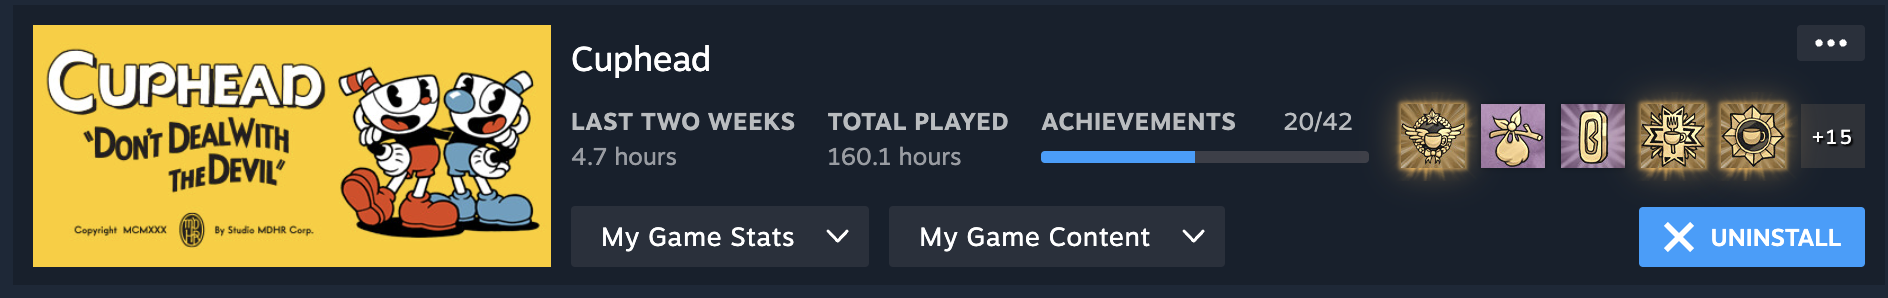
According to Steam, I've spent 160.1 hours playing Cuphead (wow!). The game is a series of unique boss battles, each demanding a different strategy. So I thought it would be fun to see if my own unconscious gameplay patterns are distinct enough for a machine to tell the bosses apart.

The data for this project is a **personal archive of my keystroke recordings from 240 fight attempts against four specific bosses (60 fights each)**: Cagney Carnation, Grim Matchstick, Baroness Von Bon Bon, and Glumstone the Giant. (see Appendix A for details on the data logger)



**Sample Log Structure:**

[View All the Raw Logs (GitHub)](https://github.com/ddanakim0304/CS156-Assignment-1/blob/main/data/raw/2025-09-23T13-52-06Z_26962.jsonl)

In [ ]:
{"meta": {"boss": "Cagney Carnation", "loadout": "Peashooter + Smoke Bomb", "difficulty": "Regular", "start_utc": "2025-09-23T13-52-06.960065+00:00"}}
{"event": "keydown", "key": "f", "t_ms": 1476}
...
{"event": "keydown", "key": "Key.space", "t_ms": 4038}
{"event": "keyup", "key": "Key.space", "t_ms": 4054}
{"summary": {"outcome": "win", "duration_ms": 74788, "end_utc": "2025-09-23T13:53:21.751994+00:00"}}

### 2. Loading the Raw Data

The raw `.jsonl` logs are just streams of events, so I transformed this sequence into a structured tabular format. I chose `pandas` for this because it provides the suitable data structure (DataFrame) and a toolkit of fast operations (.groupby, filtering, etc) that are the industry standard for cleaning and transforming data for machine learning.

#### Data Cleaning

The raw logs were cleaned by 1) normalizing timestamps, 2) removing short/accidental recordings (<5s or <10 events), 3) randomly sampling 60 fights per boss to create a balanced dataset of 240 fights, and 4) standardizing key presses into descriptive action names (ex. 'Key.space' to 'jump').

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import glob
from itertools import combinations

# Import Machine Learning Libraries
from matplotlib.colors import LogNorm
import matplotlib.patches as mpatches
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import hstack
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut
from matplotlib.colors import ListedColormap
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.base import clone
from scipy.sparse import vstack as sparse_vstack

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)


# Set a random seed for reproducibility of the sampling
np.random.seed(34) # my birthday

In [2]:
# 1. Load All Raw Data
data_path = '../data/raw/*.jsonl'
files = glob.glob(data_path)
all_events_data = []

# Iterate through each file and extract event data
for file_path in files:
    with open(file_path, 'r') as f:
        # Read all lines from the file
        lines = f.readlines()
        if not lines: continue
        try:
            meta_data = json.loads(lines[0])['meta']
            fight_id = json.loads(lines[0])['fight_id']
            boss_name = meta_data.get('boss')
            for line in lines[1:-1]:
                event_data = json.loads(line)
                if 'event' in event_data:
                    all_events_data.append({
                        'fight_id': fight_id, 'boss': boss_name,
                        'event': event_data['event'], 'key': event_data['key'],
                        't_ms': event_data['t_ms']
                    })
        except (json.JSONDecodeError, KeyError) as e:
            print(f"Skipping malformed file: {file_path}")

# Convert the list of event data into a DataFrame
raw_df = pd.DataFrame(all_events_data)
print(f"Loaded a total of {raw_df['fight_id'].nunique()} fights initially.")


# 2. Adjust Timestamps
first_action_times = raw_df.groupby('fight_id')['t_ms'].transform('min')
clean_df = raw_df.copy()
# Subtract the first action time from all timestamps in that fight to normalize them
clean_df['t_ms'] = clean_df['t_ms'] - first_action_times
print("Normalized all fight timestamps to start at t_ms = 0 from the first action.")


# 3. Filter Out Accidental Recordings
fight_stats = clean_df.groupby('fight_id')['t_ms'].agg(
    event_count='count', 
    duration_ms='max'
)
# Identify the IDs of fights that are long enough and have enough events
valid_fight_ids = fight_stats[
    (fight_stats['event_count'] >= 10) & 
    (fight_stats['duration_ms'] >= 5000)
].index
# Filter the main DataFrame to keep only valid fights
clean_df = clean_df[clean_df['fight_id'].isin(valid_fight_ids)]
print(f"Filtered down to {len(valid_fight_ids)} valid fights (>=10 events and >=5s duration).")

all_sampled_ids = []

# Get unique fight IDs along with their corresponding boss names
valid_fights_with_boss = clean_df[['fight_id', 'boss']].drop_duplicates()

for boss_name in valid_fights_with_boss['boss'].unique():
    # Get all valid fight IDs for the current boss
    boss_fight_ids = valid_fights_with_boss[valid_fights_with_boss['boss'] == boss_name]['fight_id'].unique()
    
    # Print the count before sampling
    total_fights_for_boss = len(boss_fight_ids)
    print(f"- {boss_name}: 60 fights chosen out of {total_fights_for_boss} fights")
    
    # Randomly choose 60 IDs from this boss's pool
    sampled_boss_ids = np.random.choice(boss_fight_ids, size=60, replace=False)
    
    # Add these sampled IDs to the overall list
    all_sampled_ids.extend(sampled_boss_ids)

# Filter the main DataFrame to keep only the 240 sampled fights
final_df = clean_df[clean_df['fight_id'].isin(all_sampled_ids)].reset_index(drop=True)

print(f"\nFinal balanced dataset contains {final_df['fight_id'].nunique()} fights.")
final_df.head(10)

# Standardize Action Names
key_mapping = {
    'Key.space': 'jump', 'f': 'shoot', 'd': 'dash', 'x': 'lock',
    'a': 'special attack', 'Key.up': 'up', 'Key.down': 'down', 'Key.left': 'left', 'Key.right': 'right'
}
processed_df = final_df.copy()
processed_df['action'] = processed_df['key'].map(key_mapping)
# Drop any events that weren't in the mapping
processed_df.dropna(subset=['action'], inplace=True)

Loaded a total of 278 fights initially.
Normalized all fight timestamps to start at t_ms = 0 from the first action.
Filtered down to 277 valid fights (>=10 events and >=5s duration).
- Glumstone the Giant: 60 fights chosen out of 82 fights
- Baroness Von Bon Bon: 60 fights chosen out of 60 fights
- Cagney Carnation: 60 fights chosen out of 74 fights
- Grim Matchstick: 60 fights chosen out of 61 fights

Final balanced dataset contains 240 fights.


### 3. Pre-processing and Feature Engineering

After cleaning the raw event logs, an exploratory data analysis revealed that gameplay patterns like key press duration and action frequency were distinct across bosses (see **Appendix B** for EDA plots and my thought process). This insight guided the feature engineering strategy. 

Two sets of features were created:
1. **Aggregate Statistical Features** to capture the overall pace and rhythm
2. **N-gram** Features to model the sequence of actions, capturing common gameplay combos

### Aggregate Statistical Features
This code builds my foundational feature set by calculating three distinct categories of statistics for each fight:

1.  Actions Per Minute (APM) and the percentage of total presses for each specific action (ex. `pct_jump`).
2.  The `mean`, `std`, `median`, `min`, and `max` of all press durations
3.  The `mean` and `std` of press durations for *each individual action* (ex. `jump_duration_mean`)

In [3]:
# Calculate Press Durations for all fights
def calculate_all_press_durations(df):
    """Matches every keydown to its corresponding keyup to get press durations for all fights."""
    downs = df[df['event'] == 'keydown'].copy()
    ups = df[df['event'] == 'keyup'].copy()
    
    # Create a unique ID for each press of a specific action within a fight
    downs['press_num'] = downs.groupby(['fight_id', 'action']).cumcount()
    ups['press_num'] = ups.groupby(['fight_id', 'action']).cumcount()
    
    # Merge them together to align the start and end time of each press
    merged = pd.merge(downs, ups, on=['fight_id', 'boss', 'action', 'press_num'], suffixes=('_down', '_up'))
    
    # Calculate duration and filter out any potential negative durations from data errors
    merged['duration_ms'] = merged['t_ms_up'] - merged['t_ms_down']
    return merged[merged['duration_ms'] >= 0][['fight_id', 'action', 'duration_ms']]

press_durations_df = calculate_all_press_durations(processed_df)
print("Sample of calculated press durations:")
print(press_durations_df.head())

# Foundational Feature Engineering
# Part A: Pace & Frequency Features (Action per minute (APM) and action percentages)
keydowns = processed_df[processed_df['event'] == 'keydown']
fight_summaries = keydowns.groupby('fight_id').agg(
    duration_ms=('t_ms', 'max'),
    event_count=('t_ms', 'count'),
    boss=('boss', 'first')
)
# Calculate action per minute
fight_summaries['apm'] = (fight_summaries['event_count'] / (fight_summaries['duration_ms'] / 1000.0)) * 60

# Calculate action percentages
action_percentages = keydowns.groupby(['fight_id', 'action']).size().unstack(fill_value=0).div(fight_summaries['event_count'], axis=0).add_prefix('pct_')

# Part B: Overall Rhythm Features (overall press duration statistics)
overall_duration_stats = press_durations_df.groupby('fight_id')['duration_ms'].agg(
    ['mean', 'std', 'median', 'min', 'max']
).add_prefix('overall_duration_')

# Part C: Action-Specific Timing Features (mean & std of press durations per action)
action_specific_stats = press_durations_df.groupby(['fight_id', 'action'])['duration_ms'].agg(['mean', 'std']).unstack().fillna(0)
# Flatten the multi-level column names (('mean', 'jump') -> 'mean_jump')
action_specific_stats.columns = ['_'.join(col).strip() for col in action_specific_stats.columns.values]

# Combine all foundational features into a single DataFrame
agg_features = fight_summaries.join(action_percentages).join(overall_duration_stats).join(action_specific_stats).fillna(0)

# Separate features (X) from the target variable (y)
X_agg = agg_features.drop(columns=['boss', 'duration_ms', 'event_count'])
y_str = agg_features['boss'] # Keep original string labels for plotting

# Encode target variable
le = LabelEncoder()
y = pd.Series(le.fit_transform(y_str), index=y_str.index, name='boss_encoded')
NUM_CLASSES = len(le.classes_)

print(f"\nShape of feature matrix (X_agg): {X_agg.shape}")
print("\nFirst 5 rows of the feature matrix:")
X_agg.head()

Sample of calculated press durations:
                     fight_id action  duration_ms
0  2025-09-24T10-17-07Z_27194  shoot          403
1  2025-09-24T10-17-07Z_27194   down          287
2  2025-09-24T10-17-07Z_27194   down          791
3  2025-09-24T10-17-07Z_27194  shoot          866
4  2025-09-24T10-17-07Z_27194   down         1087

Shape of feature matrix (X_agg): (240, 33)

First 5 rows of the feature matrix:


apm  pct_dash  pct_down  pct_jump  \
fight_id                                                               
2025-09-23T13-51-00Z_60041  114.321347  0.018182  0.000000  0.400000   
2025-09-23T13-53-53Z_33477  115.224478  0.042017  0.000000  0.403361   
2025-09-23T13-55-01Z_1585   106.557652  0.047170  0.000000  0.377358   
2025-09-23T13-57-05Z_25486  102.404096  0.031250  0.000000  0.437500   
2025-09-23T14-02-29Z_49949  124.101400  0.060976  0.036585  0.353659   

                            pct_left  pct_lock  pct_right  pct_shoot  \
fight_id                                                               
2025-09-23T13-51-00Z_60041  0.172727  0.018182   0.309091   0.027273   
2025-09-23T13-53-53Z_33477  0.184874  0.000000   0.285714   0.008403   
2025-09-23T13-55-01Z_1585   0.150943  0.009434   0.301887   0.018868   
2025-09-23T13-57-05Z_25486  0.132812  0.000000   0.328125   0.015625   
2025-09-23T14-02-29Z_49949  0.109756  0.000000   0.390244   0.012195   

                            pct_special attack    pct_up  ...  mean_up  \
fight_id                                                  ...            
2025-09-23T13-51-00Z_60041            0.036364  0.018182  ...   1711.0   
2025-09-23T13-53-53Z_33477            0.075630  0.000000  ...      0.0   
2025-09-23T13-55-01Z_1585             0.075472  0.018868  ...    333.0   
2025-09-23T13-57-05Z_25486            0.054688  0.000000  ...      0.0   
2025-09-23T14-02-29Z_49949            0.036585  0.000000  ...      0.0   

                             std_dash    std_down   std_jump    std_left  \
fight_id                                                                   
2025-09-23T13-51-00Z_60041   0.000000    0.000000  63.923063  189.790312   
2025-09-23T13-53-53Z_33477   6.685806    0.000000  51.093156  271.200633   
2025-09-23T13-55-01Z_1585   20.329781    0.000000  36.973232  276.202945   
2025-09-23T13-57-05Z_25486   4.830459    0.000000  59.789476  316.814719   
2025-09-23T14-02-29Z_49949  25.351529  557.311702  53.159788  121.180421   

                              std_lock   std_right     std_shoot  \
fight_id                                                           
2025-09-23T13-51-00Z_60041  1195.01046  455.944910  28987.901103   
2025-09-23T13-53-53Z_33477     0.00000  246.356487      0.000000   
2025-09-23T13-55-01Z_1585      0.00000  215.707517  41828.194534   
2025-09-23T13-57-05Z_25486     0.00000  219.255757  23143.604948   
2025-09-23T14-02-29Z_49949     0.00000  301.333428      0.000000   

                            std_special attack      std_up  
fight_id                                                    
2025-09-23T13-51-00Z_60041           19.131126  547.300649  
2025-09-23T13-53-53Z_33477           11.938500    0.000000  
2025-09-23T13-55-01Z_1585            14.267220   25.455844  
2025-09-23T13-57-05Z_25486           25.967012    0.000000  
2025-09-23T14-02-29Z_49949           17.521415    0.000000  

[5 rows x 33 columns]

### N-gram
While my foundational feature set (`X_agg`) captures the **frequency of each action** and the **statistical distribution of their press durations**, it completely ignores the *order* in which those actions occurred. To solve this, I'm borrowing a technique from text analysis called **N-grams**.

To capture only the reflexive action patterns, I only considered actions that occur within 1 second (1000ms) of each other to be part of the same combo. If there's a longer pause in my gameplay, I insert a "break (.)" in the action sequence. This prevents the model from learning meaningless long-distance associations and ensures the resulting N-gram features represent genuine gameplay combos.

Mathematical Explanation & Pseudocode for N-gram can be found in **appendix C**.

The resulting N-grams captured boss-specific combos (see **Appendix D** for a visualization of the most frequent combos per boss).

In [4]:
# Define the max time gap for an action to be part of a combo
COMBO_THRESHOLD_MS = 1000 

# Create a combined feature set with N-grams capturing action sequences
def create_combo_sentences(group):
    """
    Creates a string of actions, but inserts a '.' to break up combos
    whenever the time between actions is greater than the threshold.
    """
    # Ensure the group is sorted by time
    group = group.sort_values('t_ms')
    
    # Calculate the time difference between each action and the previous one
    time_diffs = group['t_ms'].diff().fillna(0)
    
    # Start the sentence with the first action
    sentence = [group['action'].iloc[0]]
    
    # Iterate from the second action onwards
    for i in range(1, len(group)):
        # If the gap is too large, insert a period to denote a break in the combo
        if time_diffs.iloc[i] > COMBO_THRESHOLD_MS:
            sentence.append('.')
        sentence.append(group['action'].iloc[i])
        
    return ' '.join(sentence)

# create a combined action sentences for each fight_id group for only keydown events
fight_actions_str = keydowns.groupby('fight_id').apply(create_combo_sentences)

# Engineer N-gram Features from the Combo Sentences
# The CountVectorizer will naturally treat the '.' as a word boundary

# get top 50 most frequent 2-grams and 3-grams
vectorizer = CountVectorizer(ngram_range=(2, 3), max_features=50)
ngram_features_sparse = vectorizer.fit_transform(fight_actions_str)

print("A few of the top time-aware action combos (N-grams) found:")
print(vectorizer.get_feature_names_out()[:10])

# Create the Final Enriched Feature Set (X_enriched)
# Ensure the rows of X_agg are in the same order as the fight_actions_str
X_agg_ordered = X_agg.loc[fight_actions_str.index]

# Combine the aggregated features with the N-gram features
X_enriched = hstack([X_agg_ordered.values, ngram_features_sparse]).tocsr()

print(f"\nEnriched feature set shape: {X_enriched.shape}")

A few of the top time-aware action combos (N-grams) found:
['attack jump' 'attack right' 'attack right jump' 'dash left' 'dash right'
 'down jump' 'down jump right' 'jump jump' 'jump jump jump'
 'jump jump left']

Enriched feature set shape: (240, 83)


### Final Feature List (with an example fight)

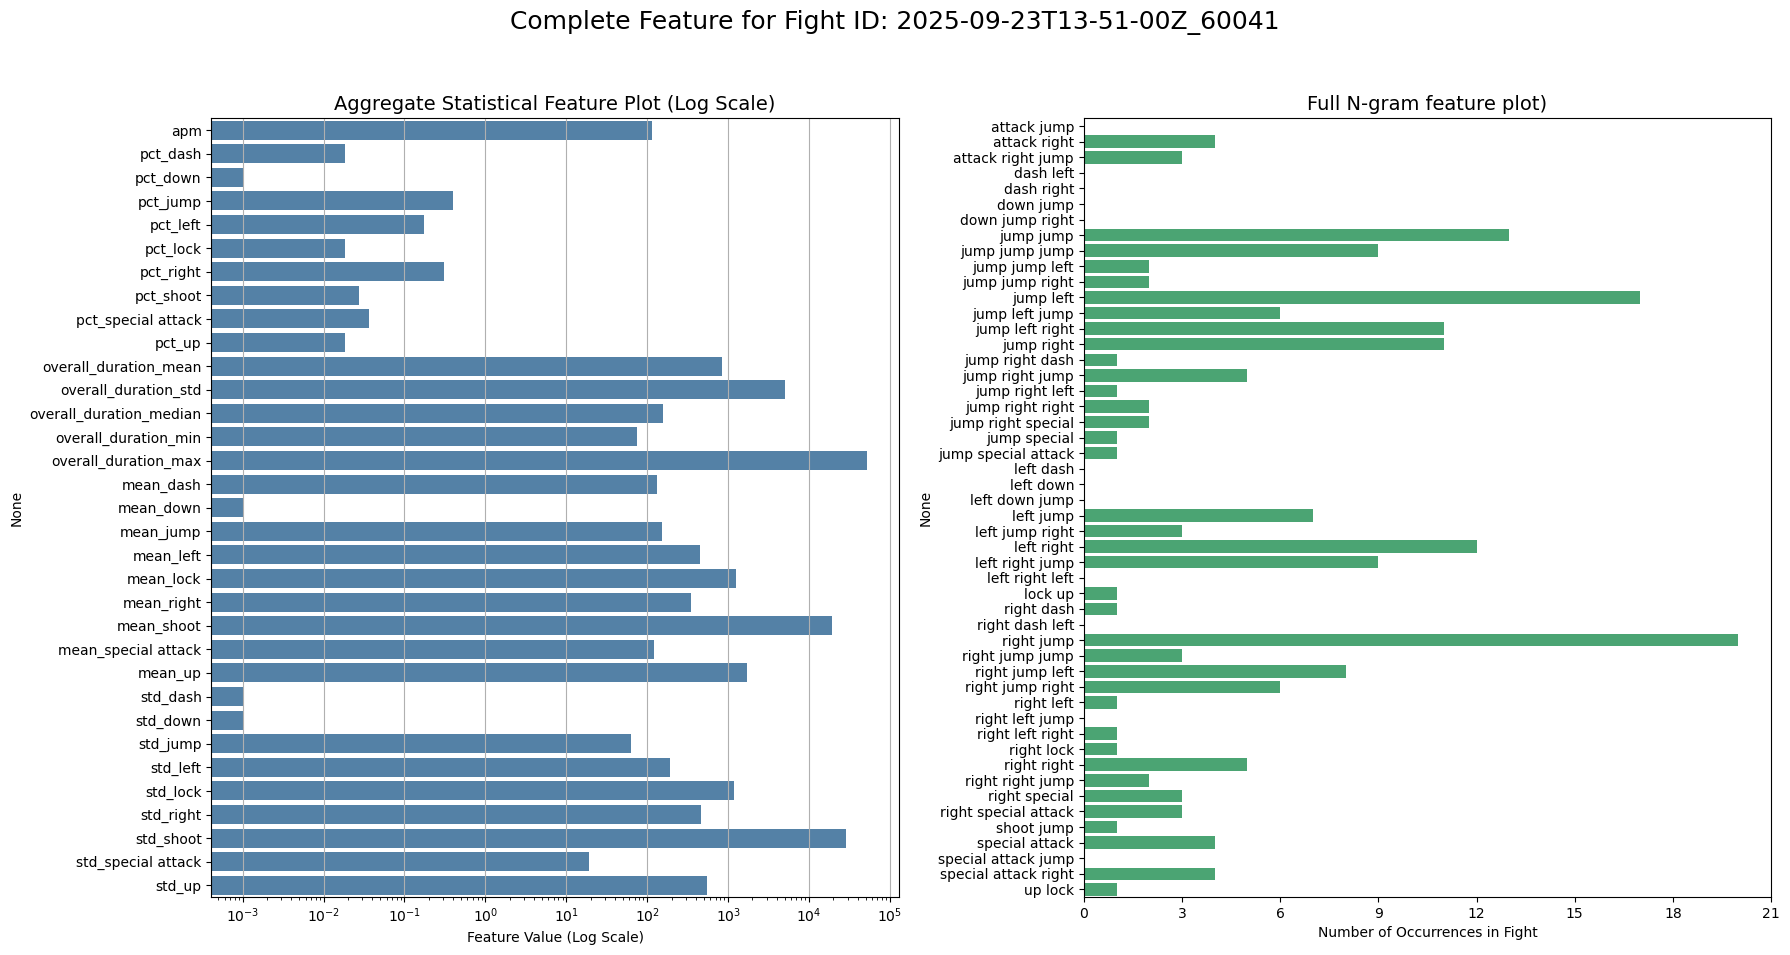

In [5]:
# 1. Get the Full List of Feature Names and a Single Vector
# get the names of all features in the enriched feature set
agg_feature_names = X_agg.columns.tolist()
ngram_feature_names = vectorizer.get_feature_names_out()
all_feature_names = agg_feature_names + list(ngram_feature_names)
# extract the feature vector for a single fight (ex. the first fight in the dataset)
single_fight_vector_sparse = X_enriched[0]
single_fight_vector_dense = single_fight_vector_sparse.toarray().flatten()
feature_series = pd.Series(single_fight_vector_dense, index=all_feature_names, name="Feature Value")


# 2. Split the Vector into its Two Logical Parts
# Part 1: Aggregate and Duration Statistics
agg_series = feature_series.loc[agg_feature_names]
# For log plot, we replace 0 with a very small number to avoid errors
agg_series_log = agg_series.replace(0, 0.001)
# Part 2: N-gram Combo Counts
ngram_series_full = feature_series.loc[ngram_feature_names]


# 3. Create the Two-Part Visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 10))
fig.suptitle(f"Complete Feature for Fight ID: {y.index[0]}", fontsize=18)

# The aggregate statistical feature plot
sns.barplot(
    x=agg_series_log.values, 
    y=agg_series_log.index, 
    orient='h', 
    ax=axes[0],
    color='steelblue'
)
axes[0].set_title('Aggregate Statistical Feature Plot (Log Scale)', fontsize=14)
# Use a log scale to show values of different magnitudes
axes[0].set_xscale('log') 
axes[0].set_xlabel('Feature Value (Log Scale)')
axes[0].grid(axis='x')

# The n-gram feature plot
sns.barplot(
    x=ngram_series_full.values, 
    y=ngram_series_full.index, 
    orient='h', 
    ax=axes[1],
    color='mediumseagreen'
)
axes[1].set_title('Full N-gram feature plot)', fontsize=14)
axes[1].set_xlabel('Number of Occurrences in Fight')
# Set x-axis ticks to be integers for counts
axes[1].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Analysis Plan

The objective is a **multi-class classification** problem: to predict the boss from my keystroke data.

## Data Splitting Strategy

To prevent data leakage between play sessions, all data splits were performed using a 'group-aware' strategy, ensuring that all fights from a single day's session remained in either the training or testing set.

The final test set was formed by selecting the 2 play sessions (out of 8 total) that created the most balanced boss distribution. The remaining 6 sessions became the development set, which was used exclusively for cross-validation (GroupKFold, LeaveOneGroupOut) and model tuning.

In [6]:
# 1. Analyze Boss Distribution Within Each Group

groups = y.index.str[:10]
unique_groups = np.unique(groups)

# Create a DataFrame to hold the counts of each boss per session
group_dist = y.groupby([groups, y]).size().unstack(fill_value=0)
print("--- Boss Distribution per Play Session ---")
display(group_dist)


# 2. Select the Best Test Groups
best_combo = None
min_imbalance = float('inf')

# Iterate through all possible combinations of 2 groups for the test set
for combo in combinations(unique_groups, 2):
    # Calculate the boss distribution for this potential test set
    test_dist = group_dist.loc[list(combo)].sum()

    # choose the combination that results in the most balanced class distribution with minimal standard deviation
    imbalance = test_dist.std()
    if imbalance < min_imbalance:
        min_imbalance = imbalance
        best_combo = list(combo)

test_groups = best_combo
dev_groups = [g for g in unique_groups if g not in test_groups]

print("\n--- Selected Top-Level Data Split ---")
print(f"Selected Test Set Groups: {test_groups}")
print(f"Remaining Development Set Groups: {dev_groups}")
print("\nTest set distribution:")
display(group_dist.loc[test_groups].sum())

# 3. Create the Final Data Splits
dev_mask = groups.isin(dev_groups)
test_mask = groups.isin(test_groups)

# The final test sets (for Section 7.1)
X_test_agg, y_test = X_agg[test_mask], y[test_mask]
X_test_enriched = X_enriched[test_mask]

# The development sets (for Section 6 cross-validation)
X_dev_agg, y_dev = X_agg[dev_mask], y[dev_mask]
X_dev_enriched = X_enriched[dev_mask]
groups_dev = groups[dev_mask]

print("\n--- Final Dataset Shapes ---")
print(f"Development set size: {len(y_dev)} samples ({len(dev_groups)} sessions)")
print(f"Test set size:  {len(y_test)} samples ({len(test_groups)} sessions)")

# 4. Define CV Strategies for the development set
cv_5fold = GroupKFold(n_splits=5)
cv_logo_dev = LeaveOneGroupOut() # Will create 6 folds for the 6 development groups

--- Boss Distribution per Play Session ---


boss_encoded   0   1   2   3
fight_id                    
2025-09-23     0   4   0  21
2025-09-24     5   0  24  15
2025-09-26    15   0  36   0
2025-09-27     0  13   0   0
2025-09-29    28  13   0   0
2025-10-04     9  18   0   0
2025-10-08     0  12   0   6
2025-10-14     3   0   0  18


--- Selected Top-Level Data Split ---
Selected Test Set Groups: ['2025-09-24', '2025-10-04']
Remaining Development Set Groups: ['2025-09-23', '2025-09-26', '2025-09-27', '2025-09-29', '2025-10-08', '2025-10-14']

Test set distribution:


boss_encoded
0    14
1    18
2    24
3    15
dtype: int64


--- Final Dataset Shapes ---
Development set size: 169 samples (6 sessions)
Test set size:  71 samples (2 sessions)


## 5. Model Selection and Mathematical Underpinnings

I compared two models: **Multinomial Logistic Regression** as an interpretable linear baseline, and an **XGBoost Classifier**. While a recurrent model like an LSTM could operate on the raw event sequence, that approach often requires a much larger dataset to avoid overfitting. My strategy instead prioritizes handcrafted feature engineering to create a rich, tabular dataset from my smaller sample size of 240 fights. As a tree-based ensemble, XGBoost is effective at capturing the complex and non-linear interactions between my features (ex. how jump frequency interacts with jump duration) that define a distinct playstyle.

### Mathematical Explanation

#### Multinomial Logistic Regression
*   **How it Works (Decision Rule):** Logistic Regression learns a linear decision boundary for each class. For an input sample $\mathbf{x}$, it computes a raw score (logit) for each class $k$ using a unique set of weights $\mathbf{w}_k$ and bias $b_k$.
    $$ z_k = \mathbf{w}_k^T \mathbf{x} + b_k $$
    for each class, which is converted to a probability via the softmax function.

*   **Objective and Optimization:** The model is trained by minimizing the Cross-Entropy Loss. While `sklearn` uses L-BFGS, the pseudocode uses the more intuitive Gradient Descent algorithm (based on class materials). In each step, it calculates how "wrong" its predictions are (the gradient) and nudges the weights in the direction that reduces this error.

*   **Regularization:** L2 regularization (controlled by the `C` hyperparameter) is used to penalize large weights and prevent overfitting.

In [ ]:
FUNCTION train_logistic_regression(X, y, learning_rate, epochs, lambda):
    """
    Trains a Multinomial Logistic Regression model using Gradient Descent.

    Args:
        X (matrix): Training data of shape (m_samples, n_features).
        y (vector): True labels, one-hot encoded, of shape (m_samples, K_classes).
        learning_rate (float): Step size for weight updates.
        epochs (int): Number of passes over the training data.
        lambda (float): L2 regularization strength.
    """
    
    // 1. Initialize weights and biases with small random values or zeros.
    m, n = shape(X)
    K = number_of_classes
    W = new Matrix(n, K) of zeros
    b = new Vector(K) of zeros
    
    // 2. Loop for a number of epochs to iteratively improve the weights.
    FOR epoch FROM 1 TO epochs:
        // 3. Forward Pass: Make predictions with current weights.
        //    a. Calculate linear scores (logits) for each class.
        logits = X @ W + b
        //    b. Apply softmax to get probabilities.
        probabilities = softmax(logits)
        
        // 4. Gradient Calculation: Find the direction to update weights.
        error = probabilities - y
        
        //    Calculate gradients for weights and biases, including the regularization term for weights.
        grad_W = (1/m) * (X.T @ error) + (lambda/m) * W
        grad_b = (1/m) * sum(error)
        
        // 5. Weight Update: Take a small step against the gradient.
        W = W - learning_rate * grad_W
        b = b - learning_rate * grad_b
        
    RETURN W, b

#### XGBoost (eXtreme Gradient Boosting)

*   **How it Works (Decision Rule):** XGBoost is a gradient boosting algorithm that sequentially builds an ensemble of decision trees, where each new tree is trained to correct the errors of its predecessors.

*   **Objective Function (Loss):** It optimizes a regularized objective function that penalizes both model complexity (number of leaves) and leaf score magnitudes, as shown in the equation below:
    $$ \text{Obj}^{(t)} = \sum_{i=1}^{n} l(y_i, \hat{y}_i^{(t-1)} + f_t(\mathbf{x}_i)) + \Omega(f_t) \quad \text{where} \quad \Omega(f_t) = \gamma T + \frac{1}{2}\lambda \sum_{j=1}^{T} w_j^2 $$
    Here, $l$ is the loss function, $f_t$ is the new tree, $T$ is the number of leaves in the tree, and $w_j$ is the score of the j-th leaf.

*   **Optimization & Regularization:**
    *   `n_estimators`: The total number of trees to build.
    *   `max_depth`: Controls the complexity of individual trees.
    *   `learning_rate` (eta): Shrinks the contribution of each new tree, a crucial technique to prevent overfitting.
    *   `gamma` and `lambda`: Directly control the penalties for tree complexity ($T$) and leaf score magnitudes ($w_j^2$) from the objective function.


In [ ]:
FUNCTION train_gradient_boosting(X, y, learning_rate, n_estimators):
    """
    Trains a Gradient Boosting model with regression trees for classification.
    (This is a simplified illustration of the core XGBoost logic).

    Args:
        X (matrix): Training data.
        y (vector): True labels (e.g., as integers 0, 1, 2, 3).
        learning_rate (float): Shrinks the contribution of each tree.
        n_estimators (int): The total number of trees to build.
    """
    
    // 1. Initialize the model with a simple base prediction.
    //    For classification, this is often the log-odds of the base class frequency.
    F_0 = calculate_initial_prediction(y)
    ensemble_prediction = F_0
    
    // 2. Loop for the number of estimators (trees) to build.
    FOR m FROM 1 TO n_estimators:
        // 3. Compute Pseudo-Residuals:
        //    Calculate the error of the current ensemble. This is the negative
        //    gradient of the loss function. For classification, this is (true_label - predicted_prob).
        current_probabilities = softmax(ensemble_prediction)
        pseudo_residuals = y - current_probabilities
        
        // 4. Train a new tree:
        //    Fit a simple Regression Tree (h_m) to predict the pseudo-residuals.
        //    This tree learns to correct the errors of the current ensemble.
        h_m = fit_regression_tree(X, pseudo_residuals)
        
        // 5. Update the ensemble:
        //    Add the new tree's predictions, scaled by the learning rate,
        //    to the overall ensemble prediction.
        ensemble_prediction = ensemble_prediction + learning_rate * h_m.predict(X)
        
    RETURN the final ensemble of trees

**The `scikit-learn` Pipeline** 

The model and its `StandardScaler` pre-processor are bundled into a `scikit-learn` Pipeline. This prevents data leakage during cross-validation by fitting the scaler only on the training data of each fold.

In [ ]:
CLASS Pipeline:
    """
    A simplified pseudocode representation of a scikit-learn Pipeline.

    Attributes:
        steps (list): A list of (name, transformer/estimator) tuples.
                      e.g., [('scaler', StandardScaler), ('logreg', LogisticRegression)]
    """
    
    FUNCTION fit(self, X_train, y_train):
        """
        Fits all transformers and the final estimator sequentially.

        Args:
            X_train (matrix): The training feature data.
            y_train (vector): The training labels.
        """
        
        // Start with the original training data.
        transformed_X = X_train
        
        // Loop through all steps EXCEPT the final one (the model).
        FOR each step (name, transformer) in self.steps[:-1]:
            // Fit the transformer on the current data and transform it.
            // The output becomes the input for the next step.
            transformed_X = transformer.fit_transform(transformed_X, y_train)
            
        // For the final step (the model), just call .fit().
        final_model = self.steps[-1][1]
        final_model.fit(transformed_X, y_train)
        
        RETURN self

    FUNCTION predict(self, X_new):
        """
        Transforms the new data and makes a prediction using the fitted model.

        Args:
            X_new (matrix): The new, unseen data to predict on.
        """
        
        // Start with the new, unseen data.
        transformed_X = X_new
        
        // Loop through all steps EXCEPT the final one (the model).
        FOR each step (name, transformer) in self.steps[:-1]:
            // Use the ALREADY FITTED transformer to just .transform() the new data.
            // No new fitting occurs here, preventing data leakage.
            transformed_X = transformer.transform(transformed_X)
            
        // For the final step (the model), call .predict() on the transformed data.
        final_model = self.steps[-1][1]
        prediction = final_model.predict(transformed_X)
        
        RETURN prediction

The code below initializes these two models within `scikit-learn` Pipelines. A `StandardScaler` is included, which is essential for Logistic Regression and a good practice that prevents features with large scales from dominating the learning process.

In [7]:
# Baseline Model: Logistic Regression
lr_pipeline = Pipeline([
    # Use with_mean=False because the enriched feature set is a sparse matrix.
    ('scaler', StandardScaler(with_mean=False)), 
    ('logreg', LogisticRegression(
        multi_class='multinomial', 
        solver='lbfgs', 
        random_state=42,
        max_iter=1000
    ))
])

# Advanced Model: XGBoost Classifier
# Pipeline maintains a consistent workflow
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('xgb', XGBClassifier(
        objective='multi:softprob',
        eval_metric='mlogloss',
        random_state=42,
        num_class=NUM_CLASSES,
        use_label_encoder=False
    ))
])

print("Baseline Model:")
print(lr_pipeline)
print("\nAdvanced Model:")
print(xgb_pipeline)

Baseline Model:
Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('logreg',
                 LogisticRegression(max_iter=1000, multi_class='multinomial',
                                    random_state=42))])

Advanced Model:
Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='mlogloss',
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                             

## 6. Model Training with Cross-Validation

To find the best model, both Logistic Regression and XGBoost were evaluated on the aggregate and enriched (aggregate + N-gram) feature sets. Performance was measured using **accuracy** via two group-aware cross-validation strategies (5-Fold GroupKFold and 6-Fold LOGO) on the development set. 

All models were initially trained with default hyperparameters to establish a performance baseline.

In [8]:
## 6. Model Training with Cross-Validation

# 1. Prepare for the Experiments
models = {
    "Logistic Regression": lr_pipeline,
    "XGBoost": xgb_pipeline
}
feature_sets = {
    "Aggregate": X_dev_agg,
    "Enriched (Agg + N-grams)": X_dev_enriched
}
cv_strategies = {
    "5-Fold GroupKFold": cv_5fold,
    "6-Fold LOGO": cv_logo_dev
}

y_dev_np = y_dev.to_numpy()
groups_dev_np = groups_dev.to_numpy()
all_classes = np.array(range(NUM_CLASSES))
results = {}

# 2. Run All Cross-Validation Experiments With a Robust Manual Loop

# Iterate through all combinations of models, feature sets, and CV strategies
for model_name, model_pipeline in models.items():
    for feature_name, X in feature_sets.items():
        for cv_name, cv_strategy in cv_strategies.items():
            
            experiment_name = f"{model_name} | {feature_name} | {cv_name}"
            print(f"\nRunning: {experiment_name}...")

            fold_scores = []
            n_splits = cv_strategy.get_n_splits(X, y_dev_np, groups_dev_np)
            
            for fold_num, (train_index, test_index) in enumerate(cv_strategy.split(X, y_dev_np, groups=groups_dev_np)):
                
                cloned_pipeline = clone(model_pipeline)
                
                X_train_fold, X_test_fold = X.iloc[train_index] if hasattr(X, 'iloc') else X[train_index], \
                                            X.iloc[test_index] if hasattr(X, 'iloc') else X[test_index]
                y_train_fold, y_test_fold = y_dev_np[train_index], y_dev_np[test_index]

                print(f"--- Fold {fold_num + 1}/{n_splits} ---")
                
                # inserts dummy samples for any missing classes in the training fold
                unique_train_classes = np.unique(y_train_fold)
                
                if len(unique_train_classes) < NUM_CLASSES:
                    print(f"  WARNING: Fold is missing classes. Original unique classes: {unique_train_classes}")
                    missing_classes = np.setdiff1d(all_classes, unique_train_classes)
                    print(f"  Injecting dummy samples for missing classes: {missing_classes}")

                    for missing_class in missing_classes:
                        # Create a dummy feature row (all zeros)
                        if hasattr(X_train_fold, 'toarray'):
                            dummy_row = np.zeros((1, X_train_fold.shape[1]))
                            X_train_fold = sparse_vstack([X_train_fold, dummy_row])
                        else:
                            dummy_row = np.zeros((1, X_train_fold.shape[1]))
                            X_train_fold = np.vstack([X_train_fold, dummy_row])
                        
                        # Add the missing class label
                        y_train_fold = np.append(y_train_fold, missing_class)

                # Fit the model
                cloned_pipeline.fit(X_train_fold, y_train_fold)
                
                # Evaluate on the test fold
                y_pred = cloned_pipeline.predict(X_test_fold)
                score = accuracy_score(y_test_fold, y_pred)
                fold_scores.append(score)
                print(f"  Fold {fold_num + 1} Score: {score:.4f}")

            # Aggregate and store results
            scores = np.array(fold_scores)
            results[experiment_name] = {
                'mean_accuracy': np.nanmean(scores),
                'std_accuracy': np.nanstd(scores),
                'all_scores': scores
            }

# 3. Display the Results
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df.sort_values(by='mean_accuracy', ascending=False, inplace=True)

print("\n--- Cross-Validation Results Summary ---")
display(results_df[['mean_accuracy', 'std_accuracy']])


Running: Logistic Regression | Aggregate | 5-Fold GroupKFold...
--- Fold 1/5 ---
  Injecting dummy samples for missing classes: [2]
  Fold 1 Score: 0.2941
--- Fold 2/5 ---
  Fold 2 Score: 0.9512
--- Fold 3/5 ---
  Fold 3 Score: 0.7200
--- Fold 4/5 ---
  Fold 4 Score: 0.9524
--- Fold 5/5 ---
  Fold 5 Score: 0.8387

Running: Logistic Regression | Aggregate | 6-Fold LOGO...
--- Fold 1/6 ---
  Fold 1 Score: 0.7200
--- Fold 2/6 ---
  Injecting dummy samples for missing classes: [2]
  Fold 2 Score: 0.2941
--- Fold 3/6 ---
  Fold 3 Score: 0.8462
--- Fold 4/6 ---
  Fold 4 Score: 0.9512
--- Fold 5/6 ---
  Fold 5 Score: 0.9444
--- Fold 6/6 ---
  Fold 6 Score: 0.9524

Running: Logistic Regression | Enriched (Agg + N-grams) | 5-Fold GroupKFold...
--- Fold 1/5 ---
  Injecting dummy samples for missing classes: [2]
  Fold 1 Score: 0.2941
--- Fold 2/5 ---
  Fold 2 Score: 0.8049
--- Fold 3/5 ---
  Fold 3 Score: 0.9600
--- Fold 4/5 ---
  Fold 4 Score: 0.9524
--- Fold 5/5 ---
  Fold 5 Score: 0.8710

Ru

mean_accuracy  \
Logistic Regression | Aggregate | 6-Fold LOGO            0.784719   
Logistic Regression | Enriched (Agg + N-grams) ...       0.776469   
Logistic Regression | Enriched (Agg + N-grams) ...       0.774688   
XGBoost | Aggregate | 6-Fold LOGO                        0.759419   
XGBoost | Enriched (Agg + N-grams) | 6-Fold LOGO         0.754728   
Logistic Regression | Aggregate | 5-Fold GroupK...       0.751286   
XGBoost | Enriched (Agg + N-grams) | 5-Fold Gro...       0.748547   
XGBoost | Aggregate | 5-Fold GroupKFold                  0.732339   

                                                    std_accuracy  
Logistic Regression | Aggregate | 6-Fold LOGO           0.234520  
Logistic Regression | Enriched (Agg + N-grams) ...      0.247802  
Logistic Regression | Enriched (Agg + N-grams) ...      0.235718  
XGBoost | Aggregate | 6-Fold LOGO                       0.236529  
XGBoost | Enriched (Agg + N-grams) | 6-Fold LOGO        0.243660  
Logistic Regression | Aggregate | 5-Fold GroupK...      0.244146  
XGBoost | Enriched (Agg + N-grams) | 5-Fold Gro...      0.245357  
XGBoost | Aggregate | 5-Fold GroupKFold                 0.242313

### Justification for the Dummy Sample Injection
Certain cross-validation folds were missing a class, causing the XGBoost model to fail. To resolve this, I injected a single "dummy" sample with a zero-feature vector for any missing class in the problematic folds. While this introduces a negligible amount of artificial data, this solution ensures all folds are used for a complete performance estimate, which is more accurate than discarding the failing folds.

## 6.1 Hyperparameter Tuning the Best Model

The best model from Section 6 was **Logistic Regression with the Aggregate feature set and 6-Fold LOGO CV**.

In the code, I used `GridSearchCV` to systematically test a range of hyperparameter values for a model to find the combination that performs the best.

In [9]:
from sklearn.model_selection import GridSearchCV

# load the best model pipeline from Section 6
tuning_pipeline = lr_pipeline

# Define the grid of hyperparameters
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100]
}

# Set up GridSearchCV using the group-aware CV strategy
grid_search = GridSearchCV(
    estimator=tuning_pipeline,
    param_grid=param_grid,
    cv=cv_logo_dev,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Run the search on the development data with the aggregate feature set
grid_search.fit(X_dev_agg, y_dev, groups=groups_dev)

print("\n--- GridSearchCV Results ---")
print(f"Best cross-validated accuracy: {grid_search.best_score_:.4f}")
print("Best hyperparameters found:")
print(grid_search.best_params_)

# 6. Store the best model for the final evaluation in Section 7
best_tuned_model = grid_search.best_estimator_

Fitting 6 folds for each of 5 candidates, totalling 30 fits

--- GridSearchCV Results ---
Best cross-validated accuracy: 0.7949
Best hyperparameters found:
{'logreg__C': 100}


#### GridSearchCV Pseudo code

In [ ]:
FUNCTION GridSearchCV(estimator, param_grid, X_data, y_data, cv_splitter, scoring_function):

  // Initialize variables to keep track of the best results
  best_score = -infinity
  best_params = null
  all_results = []

  // Generate all unique combinations of hyperparameters from the param_grid
  parameter_combinations = generate_combinations(param_grid)

  // --- Main Loop: Iterate over each hyperparameter combination ---
  FOR EACH current_params IN parameter_combinations:
    
    // Create a list to store the scores for each fold
    fold_scores = []

    // Get the data splits (e.g., 5 folds of train/validation indices)
    cv_splits = cv_splitter.get_splits(X_data, y_data)

    // --- Cross-Validation Loop: Iterate over each fold ---
    FOR EACH (train_indices, validation_indices) IN cv_splits:

      // 1. Split the data for this fold
      X_train, y_train = get_data_from_indices(X_data, y_data, train_indices)
      X_validation, y_validation = get_data_from_indices(X_data, y_data, validation_indices)

      // 2. Create a new instance of the model to ensure it's untrained
      model = create_new_instance(estimator)

      // 3. Set the current hyperparameters on the new model
      model.set_parameters(current_params)

      // 4. Train the model on the training data for this fold
      model.fit(X_train, y_train)

      // 5. Evaluate the model on the validation data
      predictions = model.predict(X_validation)
      score = scoring_function(y_validation, predictions)

      // 6. Add the score for this fold to the list
      APPEND score TO fold_scores

    // --- End of Cross-Validation Loop ---

    // Calculate the average score across all folds for the current_params
    average_score = calculate_average(fold_scores)
    
    // Store the results for inspection later
    APPEND {params: current_params, score: average_score} TO all_results

    // Check if this combination of parameters is the best one so far
    IF average_score > best_score:
      best_score = average_score
      best_params = current_params

  // --- End of Main Loop ---

  // After checking all combinations, refit the model on the ENTIRE dataset
  // using the best parameters found
  best_estimator = create_new_instance(estimator)
  best_estimator.set_parameters(best_params)
  best_estimator.fit(X_data, y_data)

  // Return the best findings
  RETURN {
    'best_params_': best_params,
    'best_score_': best_score,
    'best_estimator_': best_estimator,
    'all_results_': all_results
  }

END FUNCTION

## 7. Generating Out-of-Sample Predictions and Performance Metrics
Having selected and tuned the best model in the previous section—**Logistic Regression with a C value of 100, trained on Aggregate features**—it is now time for the final evaluation. This model will be used to make predictions on the untouched test set.

### 7.1 Performance on the Untouched Test Set

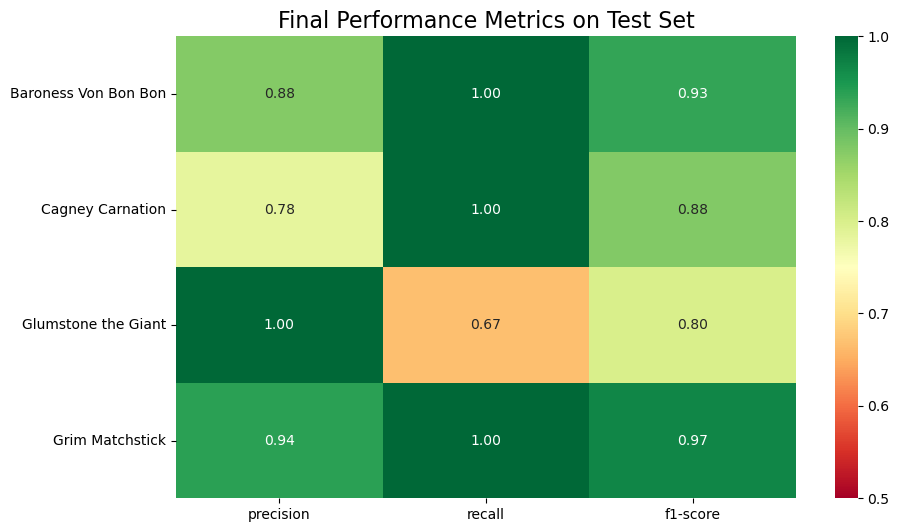

                      precision    recall  f1-score   support

Baroness Von Bon Bon       0.88      1.00      0.93        14
    Cagney Carnation       0.78      1.00      0.88        18
 Glumstone the Giant       1.00      0.67      0.80        24
     Grim Matchstick       0.94      1.00      0.97        15

            accuracy                           0.89        71
           macro avg       0.90      0.92      0.89        71
        weighted avg       0.91      0.89      0.88        71



In [10]:
# 1. Use the best tuned model to predict on the test set
final_predictions_encoded = best_tuned_model.predict(X_test_agg)

# 2. Compute and Visualize the Classification Report
report_dict = classification_report(
    y_true=y_test, 
    y_pred=final_predictions_encoded, 
    target_names=le.classes_,
    output_dict=True
)
report_df = pd.DataFrame(report_dict).transpose()
report_df_for_plot = report_df.drop(columns='support')

plt.figure(figsize=(10, 6))
sns.heatmap(
    report_df_for_plot.iloc[:-3, :],
    annot=True, 
    cmap='RdYlGn',
    fmt='.2f',
    vmin=0.5,
    vmax=1.0
)
plt.title('Final Performance Metrics on Test Set', fontsize=16)
plt.show()

print(classification_report(y_true=y_test, y_pred=final_predictions_encoded, target_names=le.classes_))




### Performance Metrics Analysis

The model achieved **perfect recall (1.00) for three of the four bosses**. Its primary weakness was a **significantly lower recall of 0.67 for Glumstone the Giant** and a **reduced precision of 0.78 for Cagney Carnation**.

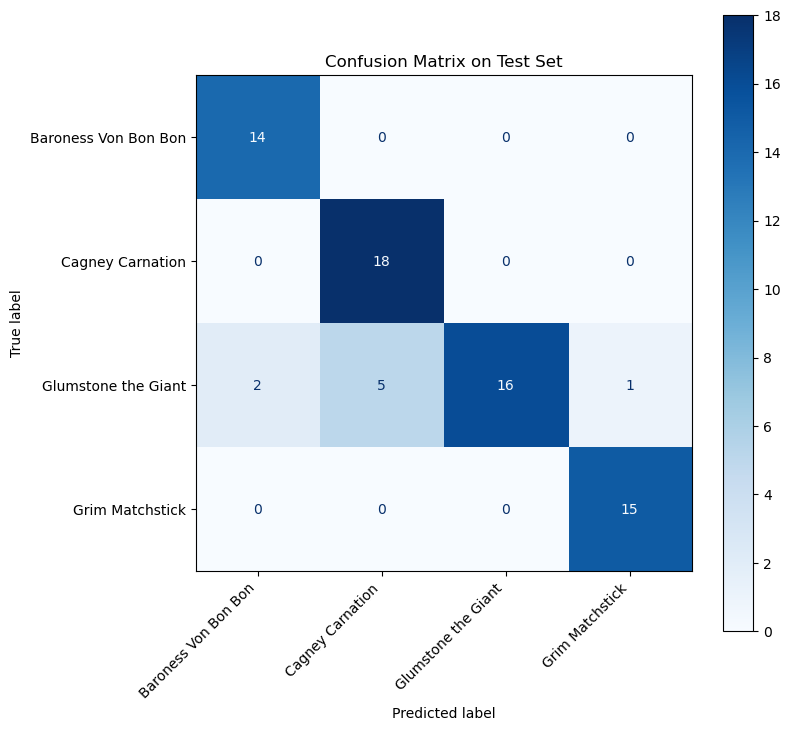

In [11]:
# 3. Visualize the Confusion Matrix for the Test Set Predictions 
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_test, 
    y_pred=final_predictions_encoded,
    display_labels=le.classes_,
    cmap='Blues',
    ax=ax
)
ax.set_title('Confusion Matrix on Test Set')
plt.xticks(rotation=45, ha='right')
plt.show()

### Analysis of Misclassified Fights
The confusion matrix confirms this strength, showing a perfect diagonal for Baroness, Cagney, and Grim.

The matrix pinpoints the model's primary weakness: 8 of 24 Glumstone fights were misclassified, with 5 being mistaken for Cagney Carnation. This error pattern directly explains Glumstone's low recall and Cagney's reduced precision.

### 7.2 Final Validation on a Truly Unseen Dataset (Extension)

While cross-validation provides a good estimate of performance, the ultimate test of a model is on truly unseen data collected *after* the main analysis. To perform this final validation, I will process a new 'holdout' set of gameplay logs using the exact same feature pipeline. I will then use my best model, retrained on the full original 240-fight dataset, to make predictions on this new data and calculate a final, unbiased accuracy score.

[Full New ✨ Raw dataset (Github)](https://github.com/ddanakim0304/CS156-Assignment-1/tree/main/data/raw_new)

Loading 28 new fights from the holdout set...

Retraining the best model on the full original 240-fight dataset...
Retraining complete.

--- Final Performance on New Holdout Set (from 2025/10/19) ---
Accuracy on truly unseen data: 0.7857

Classification Report:
                      precision    recall  f1-score   support

Baroness Von Bon Bon       1.00      0.71      0.83         7
    Cagney Carnation       0.70      1.00      0.82         7
 Glumstone the Giant       0.80      0.57      0.67         7
     Grim Matchstick       0.75      0.86      0.80         7

            accuracy                           0.79        28
           macro avg       0.81      0.79      0.78        28
        weighted avg       0.81      0.79      0.78        28


--- Performance Report on Holdout Set ---


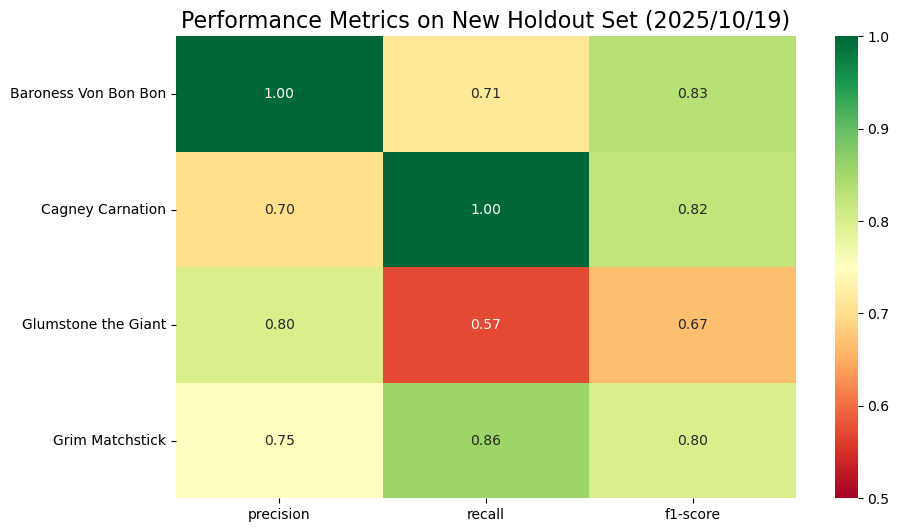


--- Confusion Matrix for Holdout Set ---


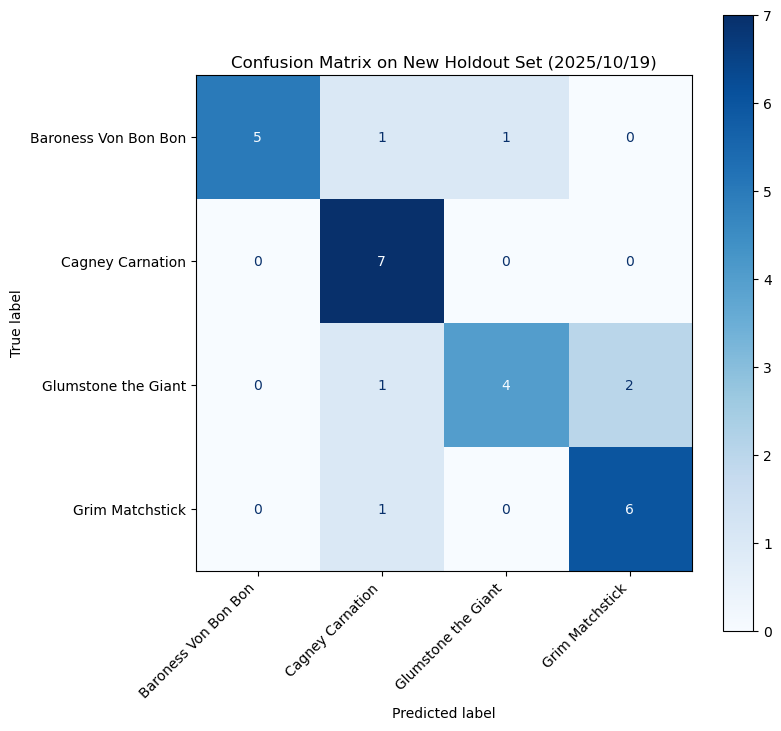

In [12]:
# 1. Load the New Holdout Data from the New Directory
new_data_path = '../data/raw_new/*.jsonl'
new_files = glob.glob(new_data_path)
new_events_data = []

print(f"Loading {len(new_files)} new fights from the holdout set...")


# Load and process each new file
for file_path in new_files:
    with open(file_path, 'r') as f:
        lines = f.readlines()
        if not lines: continue
        try:
            meta_data = json.loads(lines[0])['meta']
            fight_id = json.loads(lines[0])['fight_id']
            boss_name = meta_data.get('boss')
            for line in lines[1:-1]:
                event_data = json.loads(line)
                if 'event' in event_data:
                    new_events_data.append({
                        'fight_id': fight_id, 'boss': boss_name,
                        'event': event_data['event'], 'key': event_data['key'],
                        't_ms': event_data['t_ms']
                    })
        except (json.JSONDecodeError, KeyError) as e:
            print(f"Skipping malformed file in new data: {file_path}")

raw_df_new = pd.DataFrame(new_events_data)

# 2. Apply the same Pre-processing and Feature Engineering Pipeline (Section 2 & 3)

# Adjust timestamps
first_action_times_new = raw_df_new.groupby('fight_id')['t_ms'].transform('min')
clean_df_new = raw_df_new.copy()
clean_df_new['t_ms'] = clean_df_new['t_ms'] - first_action_times_new

# Standardize action names
processed_df_new = clean_df_new.copy()
processed_df_new['action'] = processed_df_new['key'].map(key_mapping)
processed_df_new.dropna(subset=['action'], inplace=True)

# Engineer Aggregate features using the same functions and logic
press_durations_df_new = calculate_all_press_durations(processed_df_new)
keydowns_new = processed_df_new[processed_df_new['event'] == 'keydown']
fight_summaries_new = keydowns_new.groupby('fight_id').agg(
    duration_ms=('t_ms', 'max'), event_count=('t_ms', 'count'), boss=('boss', 'first')
)
fight_summaries_new['apm'] = (fight_summaries_new['event_count'] / (fight_summaries_new['duration_ms'] / 1000.0)) * 60
action_percentages_new = keydowns_new.groupby(['fight_id', 'action']).size().unstack(fill_value=0).div(fight_summaries_new['event_count'], axis=0).add_prefix('pct_')
overall_duration_stats_new = press_durations_df_new.groupby('fight_id')['duration_ms'].agg(['mean', 'std', 'median', 'min', 'max']).add_prefix('overall_duration_')
action_specific_stats_new = press_durations_df_new.groupby(['fight_id', 'action'])['duration_ms'].agg(['mean', 'std']).unstack().fillna(0)
action_specific_stats_new.columns = ['_'.join(col).strip() for col in action_specific_stats_new.columns.values]

agg_features_new = fight_summaries_new.join(action_percentages_new).join(overall_duration_stats_new).join(action_specific_stats_new).fillna(0)

# Ensure the holdout feature set has the exact same columns as the training set
X_holdout_agg = agg_features_new.reindex(columns=X_agg.columns, fill_value=0)
y_holdout_str = agg_features_new['boss']

# Use the previously fitted LabelEncoder to transform the new labels
y_holdout_encoded = le.transform(y_holdout_str)

# --- 3. Retrain the Best Model on the Full Original Dataset ---
print("\nRetraining the best model on the full original 240-fight dataset...")
# Clone the model to ensure it's a fresh instance
final_model_for_holdout = clone(best_tuned_model)
# Train on the full original dataset (X_agg and y)
final_model_for_holdout.fit(X_agg, y)
print("Retraining complete.")

# 4. Make Predictions and Evaluate on the New Holdout Data
holdout_predictions = final_model_for_holdout.predict(X_holdout_agg)

# Calculate and print the final performance
holdout_accuracy = accuracy_score(y_holdout_encoded, holdout_predictions)

print("\n--- Final Performance on New Holdout Set (from 2025/10/19) ---")
print(f"Accuracy on truly unseen data: {holdout_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_holdout_encoded, holdout_predictions, target_names=le.classes_))

# 5. Visualize the Performance on the Holdout Set

# A. Performance Metrics Heatmap
print("\n--- Performance Report on Holdout Set ---")
report_dict_holdout = classification_report(
    y_true=y_holdout_encoded, 
    y_pred=holdout_predictions, 
    target_names=le.classes_,
    output_dict=True
)
report_df_holdout = pd.DataFrame(report_dict_holdout).transpose()
report_df_for_plot_holdout = report_df_holdout.drop(columns='support')

plt.figure(figsize=(10, 6))
sns.heatmap(
    report_df_for_plot_holdout.iloc[:-3, :],
    annot=True, 
    cmap='RdYlGn',
    fmt='.2f',
    vmin=0.5,
    vmax=1.0
)
plt.title('Performance Metrics on New Holdout Set (2025/10/19)', fontsize=16)
plt.show()


# B. Confusion Matrix
print("\n--- Confusion Matrix for Holdout Set ---")
fig, ax = plt.subplots(figsize=(8, 8))
ConfusionMatrixDisplay.from_predictions(
    y_true=y_holdout_encoded, 
    y_pred=holdout_predictions,
    display_labels=le.classes_,
    cmap='Blues',
    ax=ax
)
ax.set_title('Confusion Matrix on New Holdout Set (2025/10/19)')
plt.xticks(rotation=45, ha='right')
plt.show()

## 8. Discussion and Conclusions

This project successfully demonstrated that my keystroke data contains distinct signatures for different Cuphead bosses. A tuned Logistic Regression model validated this by effectively separating my typical playstyles, performing especially well on bosses I had frequently practiced against.

The model's primary weakness—a low recall for Glumstone the Giant—provided the deepest insight. This data was captured during my first encounters with the boss (while I was already familiar with other bosses), meaning my playstyle was erratic and experimental. The model failed not because it couldn't separate two bosses, but because it could not classify this inconsistent "learning" playstyle, defaulting to a practiced one instead.

To prove this, I used the model's coefficients to identify the 5 most influential features for a diagnostic visualization.

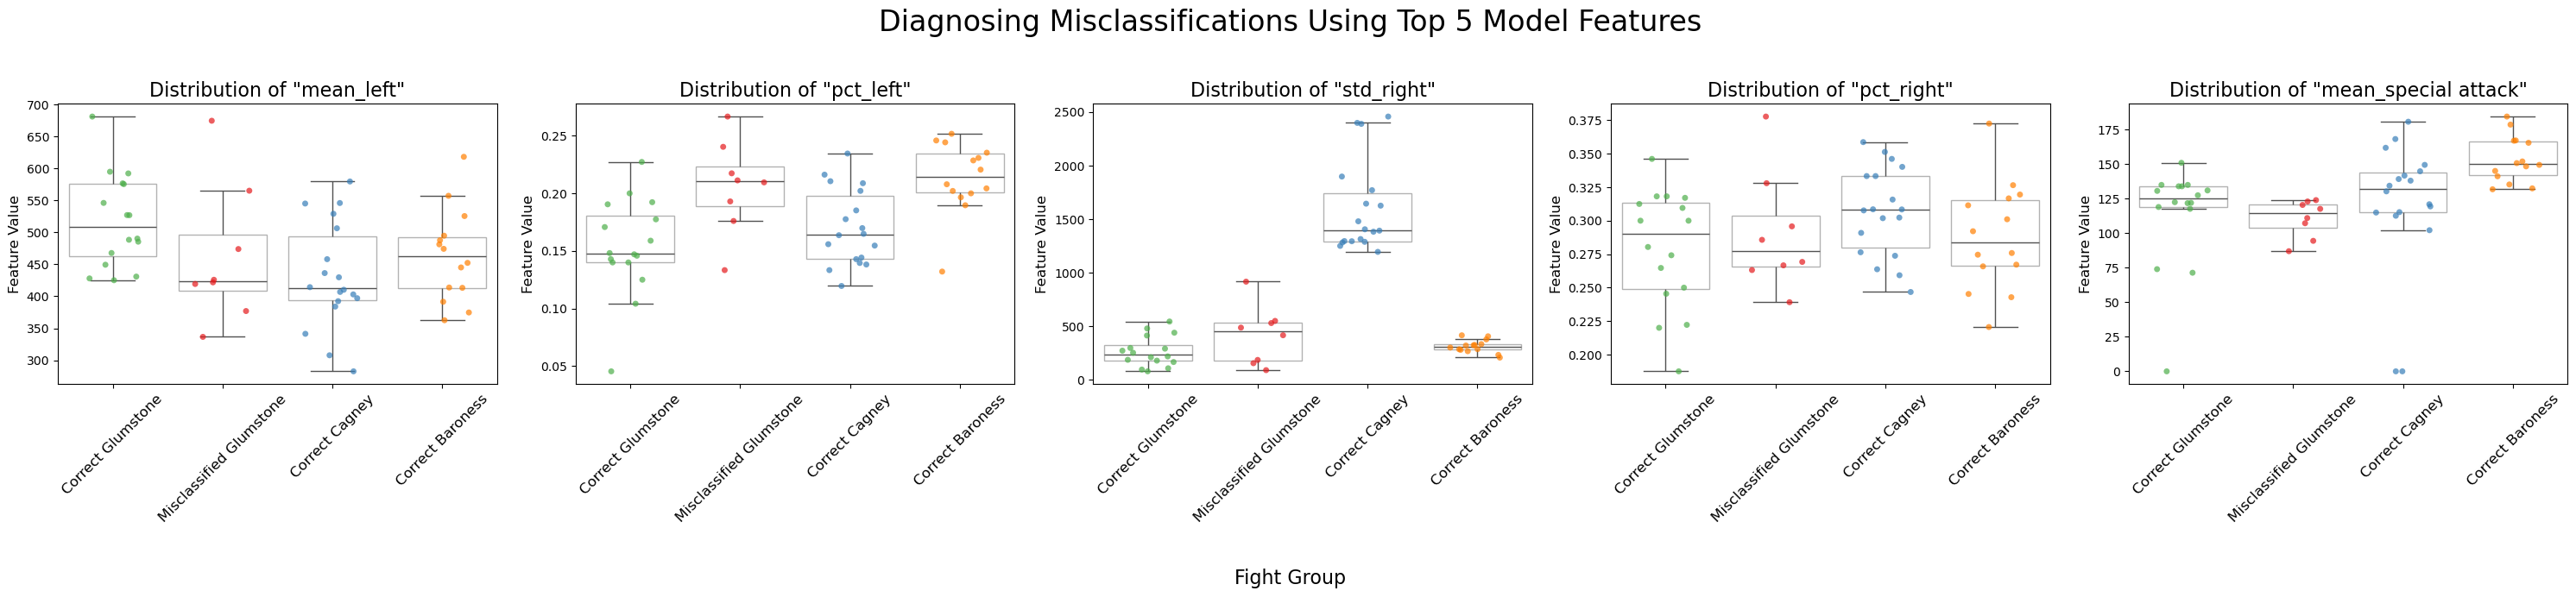

In [14]:
# 1. Data-Driven Feature Selection Using Model Coefficients
# Extract feature importance from the final logistic regression model
final_logreg_model = best_tuned_model.named_steps['logreg']
feature_names = X_agg.columns.tolist()

# Create a DataFrame of coefficients for easier analysis
coef_df = pd.DataFrame(final_logreg_model.coef_, columns=feature_names, index=le.classes_)
# Calculate the standard deviation of coefficients across classes as a measure of importance
feature_importance = coef_df.std(axis=0).sort_values(ascending=False)
features_to_compare = feature_importance.head(5).index.tolist()

# 2. Isolate All Relevant Groups from the Test Set
analysis_df_test = agg_features.loc[y_test.index].copy()
analysis_df_test['true_label'] = le.inverse_transform(y_test)
analysis_df_test['predicted_label'] = le.inverse_transform(final_predictions_encoded)
analysis_df_test['status'] = np.where(analysis_df_test['true_label'] == analysis_df_test['predicted_label'], 'Correct', 'Incorrect')

# Isolate the four groups of interest
glumstone_correct = analysis_df_test[(analysis_df_test['true_label'] == 'Glumstone the Giant') & (analysis_df_test['status'] == 'Correct')].copy()
cagney_correct = analysis_df_test[(analysis_df_test['true_label'] == 'Cagney Carnation') & (analysis_df_test['status'] == 'Correct')].copy()
bonbon_correct = analysis_df_test[(analysis_df_test['true_label'] == 'Baroness Von Bon Bon') & (analysis_df_test['status'] == 'Correct')].copy()
glumstone_misclassified = analysis_df_test[(analysis_df_test['true_label'] == 'Glumstone the Giant') & (analysis_df_test['status'] == 'Incorrect')].copy()

glumstone_correct['group'] = 'Correct Glumstone'
cagney_correct['group'] = 'Correct Cagney'
bonbon_correct['group'] = 'Correct Baroness'
glumstone_misclassified['group'] = 'Misclassified Glumstone'

comparison_df = pd.concat([glumstone_correct, cagney_correct, bonbon_correct, glumstone_misclassified])

# 3. Create the Side-by-Side Diagnostic Plots
fig, axes = plt.subplots(1, 5, figsize=(30, 7), sharey=False)
fig.suptitle('Diagnosing Misclassifications Using Top 5 Model Features', fontsize=24)
palette = {
    'Correct Glumstone': '#4daf4a', 
    'Misclassified Glumstone': '#e41a1c', 
    'Correct Cagney': '#377eb8',
    'Correct Baroness': '#ff7f00'
}

# Plot each feature
for i, feature in enumerate(features_to_compare):
    ax = axes[i]
    sns.stripplot(data=comparison_df, x='group', y=feature, ax=ax, palette=palette, jitter=0.25, alpha=0.7, 
                  order=['Correct Glumstone', 'Misclassified Glumstone', 'Correct Cagney', 'Correct Baroness'])
    sns.boxplot(data=comparison_df, x='group', y=feature, ax=ax, boxprops=dict(alpha=.3, facecolor='none', edgecolor='black'), 
                showfliers=False, order=['Correct Glumstone', 'Misclassified Glumstone', 'Correct Cagney', 'Correct Baroness'])
    ax.set_title(f'Distribution of "{feature}"', fontsize=16)
    ax.set_xlabel(None)
    ax.set_ylabel('Feature Value', fontsize=12)
    ax.tick_params(axis='x', rotation=45, labelsize=12)

fig.supxlabel('Fight Group', fontsize=16, y=0.02)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

Based on this plot, the distribution of the "Misclassified Glumstone" fights (in red) is visibly distinct from the "Correct Glumstone" fights (in green) and is more similar to the patterns of "Correct Cagney" (in blue) or "Correct Baroness" (in orange). For example, the misclassified fights exhibit a significantly lower average press duration for the 'left' key (`mean_left`), patterns that are characteristic of the Cagney encounter. This visualization confirms that the model was not failing randomly; it correctly identified that the player's "learning" playstyle in those specific fights was statistically dissimilar to their established Glumstone strategy. However, because this different pattern shared key statistical features with other bosses, the model made a logical error, classifying an unfamiliar playstyle as a familiar one.

This also explains the performance drop on the new holdout data, collected after a 5-day gap. The model’s core limitation is a fundamental difficulty in classifying inconsistent gameplay, whether from learning a new boss or the natural drift in my skills over time.

## 9. Executive Summary

This project documents the creation of a machine learning pipeline to classify which of four *Cuphead* bosses I am fighting based solely on my keystroke data. By transforming raw key presses into statistical feature profiles, a tuned Logistic Regression model successfully learned to differentiate my gameplay patterns with high accuracy, demonstrating that my unconscious playstyles contain distinct & learnable signatures.

#### Pipeline Overview

The project followed a iterative process moving from raw data collection to final evaluation.
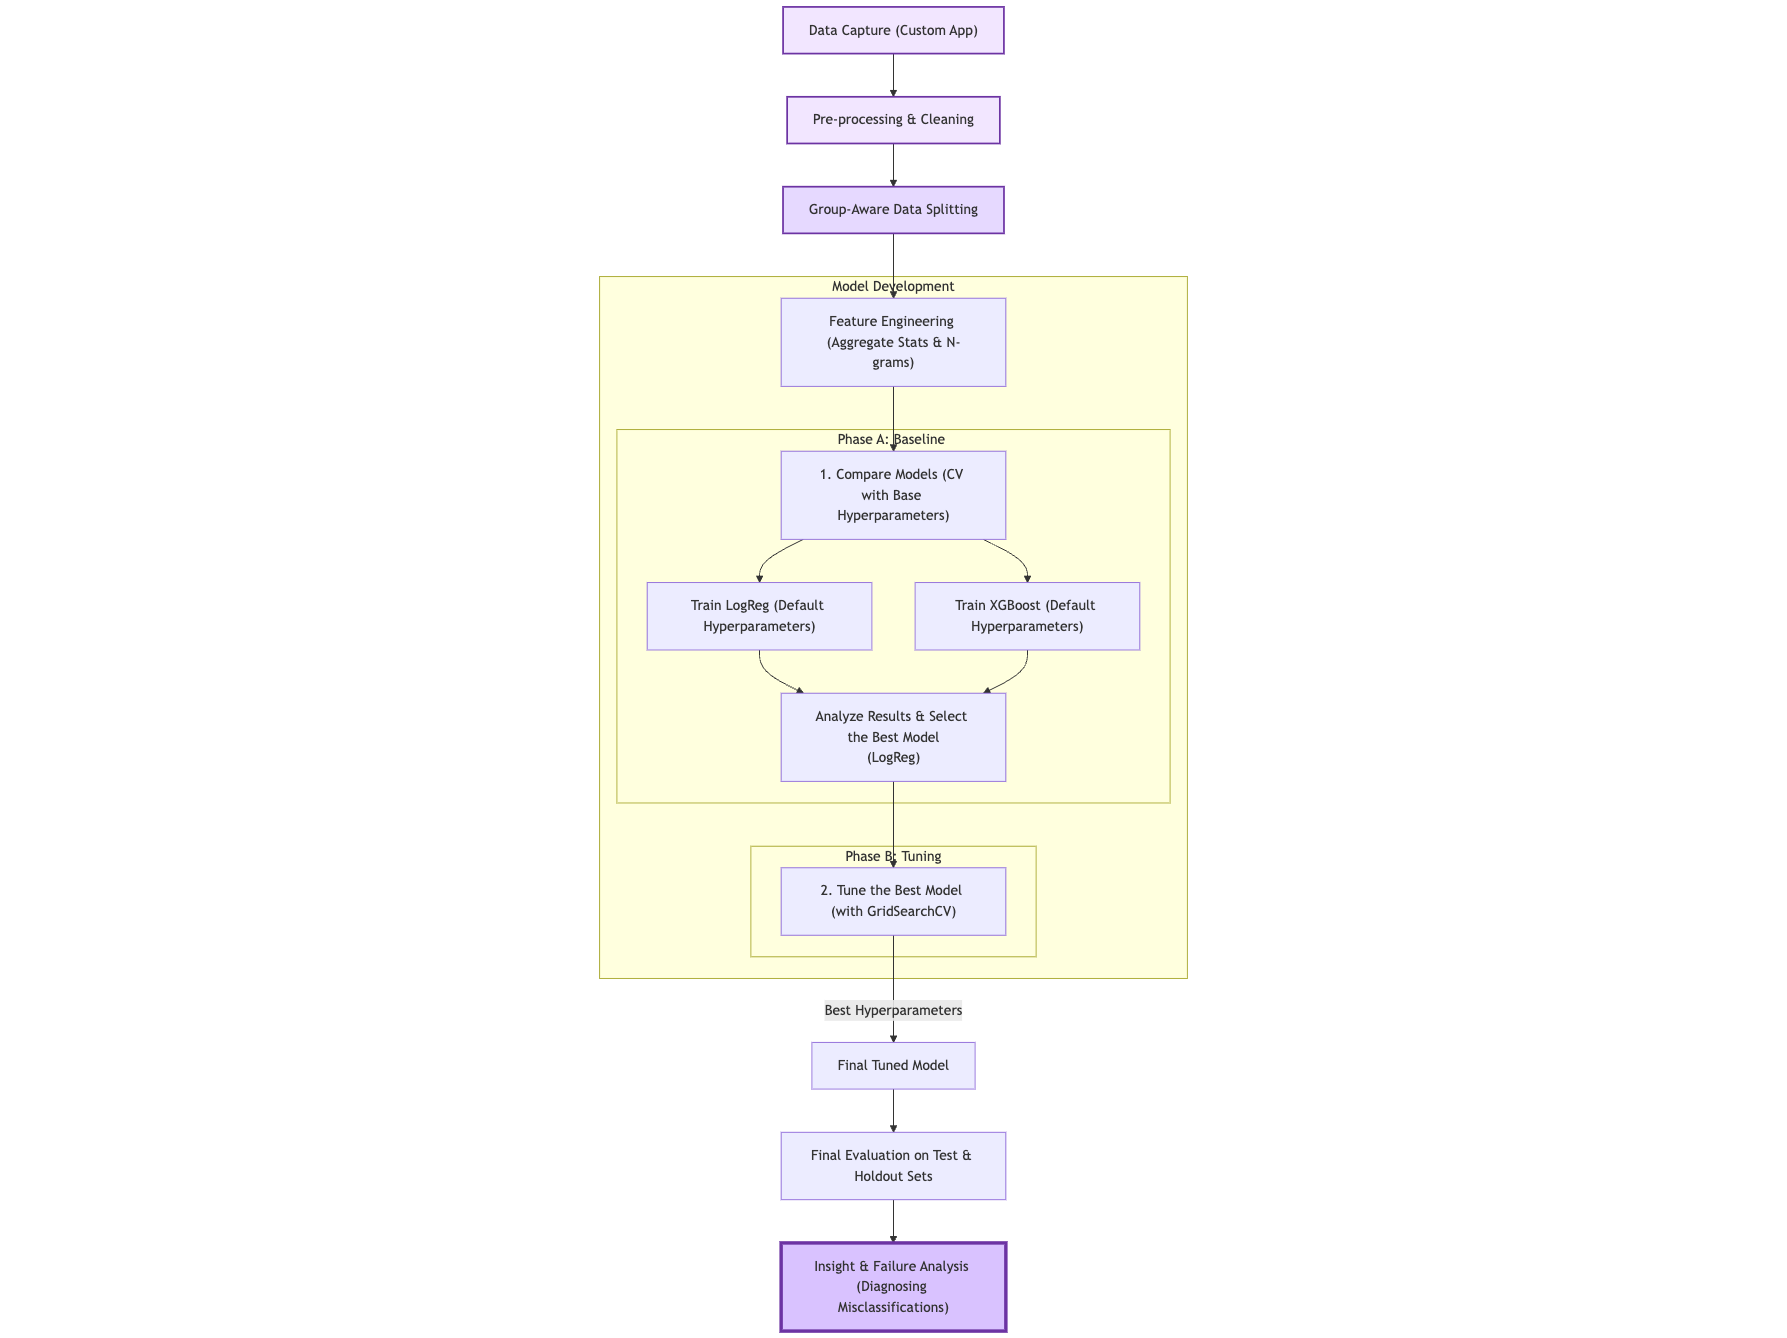

#### Key Results and Insights

A **tuned Logistic Regression model using aggregate statistical features** was found to be most effective. It performed exceptionally well on a test set but saw performance degrade on a holdout set collected days later, highlighting a struggle to generalize over time.

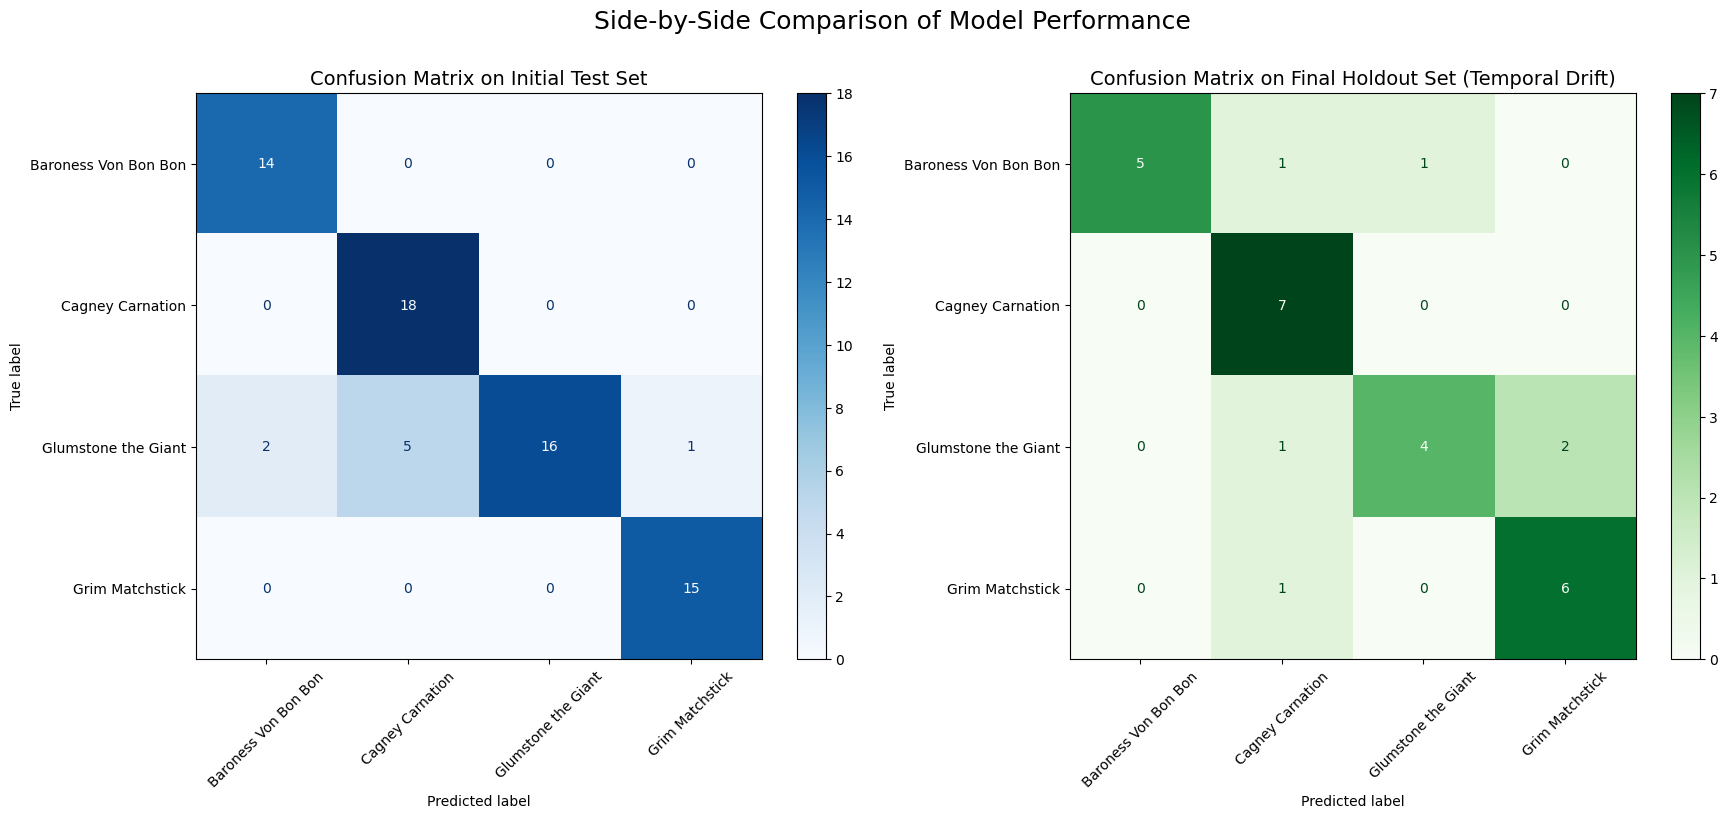


The key insight, derived from the failure analysis in Section 8, was that the model's errors were not random. It struggled to classify my inconsistent 'learning-phase' playstyle for a new boss, logically misclassifying it as a more familiar pattern. This difficulty in categorizing high-variance gameplay, whether from learning or skill drift over time, was identified as the model's core limitation.

#### Shortcomings and Future Improvements

This analysis confirmed the model's viability but also highlighted key limitations that provide a clear path for future work:
*   While Logistic Regression performed well, the persistent confusion between bosses suggests a time-aware model (like LSTM) might be able to capture the more subtle differences that the linear model missed.
*   The aggregate features, while effective, were sensitive to changes in my playstyle over time. Future work could focus on engineering features that are more robust to this temporal drift.
*   The dataset captures only my personal playstyle. To create a more generalizable model, data would need to be collected from multiple players.
*   Varying game settings like difficulty and loadouts would introduce controlled variations in playstyle, testing if the model can learn features that are truly boss-specific rather than just strategy-specific.

# References

- Minerva University. (2025, October 15). CS156 Session 9 - Metrics and Cross-Validation [Class Lecture]. Forum. https://forum.minerva.edu/app/courses/3678/sections/12801/classes/95069
- Murphy, K. P. (2022). Probabilistic Machine Learning: An Introduction. MIT Press.
- Chen, T., & Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. In Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining (pp. 785–794).
- Pedregosa, F., et al. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825-2830.
- Scikit-learn Developers. (n.d.). User Guide. Scikit-learn. Retrieved October 20, 2025, from https://scikit-learn.org/stable/user_guide.html.
- Starmer, J. (Host). (n.d.). StatQuest: Logistic Regression [Video]. YouTube. Retrieved October 20, 2025, from https://www.youtube.com/watch?v=yIYKR4sgzI8

## AI Statement


*   In the early stages, I used the assistant to brainstorm the report's structure, discussing how to best fit my iterative modeling approach (from simple aggregates to N-grams) into the 10-section rubric.
*   The AI acted as a writing partner. I would write a draft of a section in my own voice, and then ask for suggestions on making it more concise or improving its flow. This was particularly helpful for the more technical sections.
*   I used the assistant to critique my model choices. We discussed the pros and cons of using an LSTM versus XGBoost, which helped me solidify my own reasoning for choosing XGBoost as an appropriate step-up in complexity that better suited my tabular data.
*   For specific, non-analytical tasks, I used the AI to generate boilerplate syntax. This included creating the `matplotlib` code for a boxplot after I specified the variables and data, or creating the Mermaid syntax for a pipeline diagram once I had finalized all the steps myself.
*   My own review was a critical part of the process. For example, I corrected a logical flaw in an early AI-suggested code block for calculating press durations to ensure it correctly handled all edge cases, demonstrating that I was actively guiding and verifying the technical implementation.
*   As a final step, I used the assistant for a last-pass proofread to catch minor spelling and grammatical errors, similar to using a tool like Grammarly.

## Appendices



### Appendix A: How the Data Was Obtained and Sampled

### A-1. Data Logger App

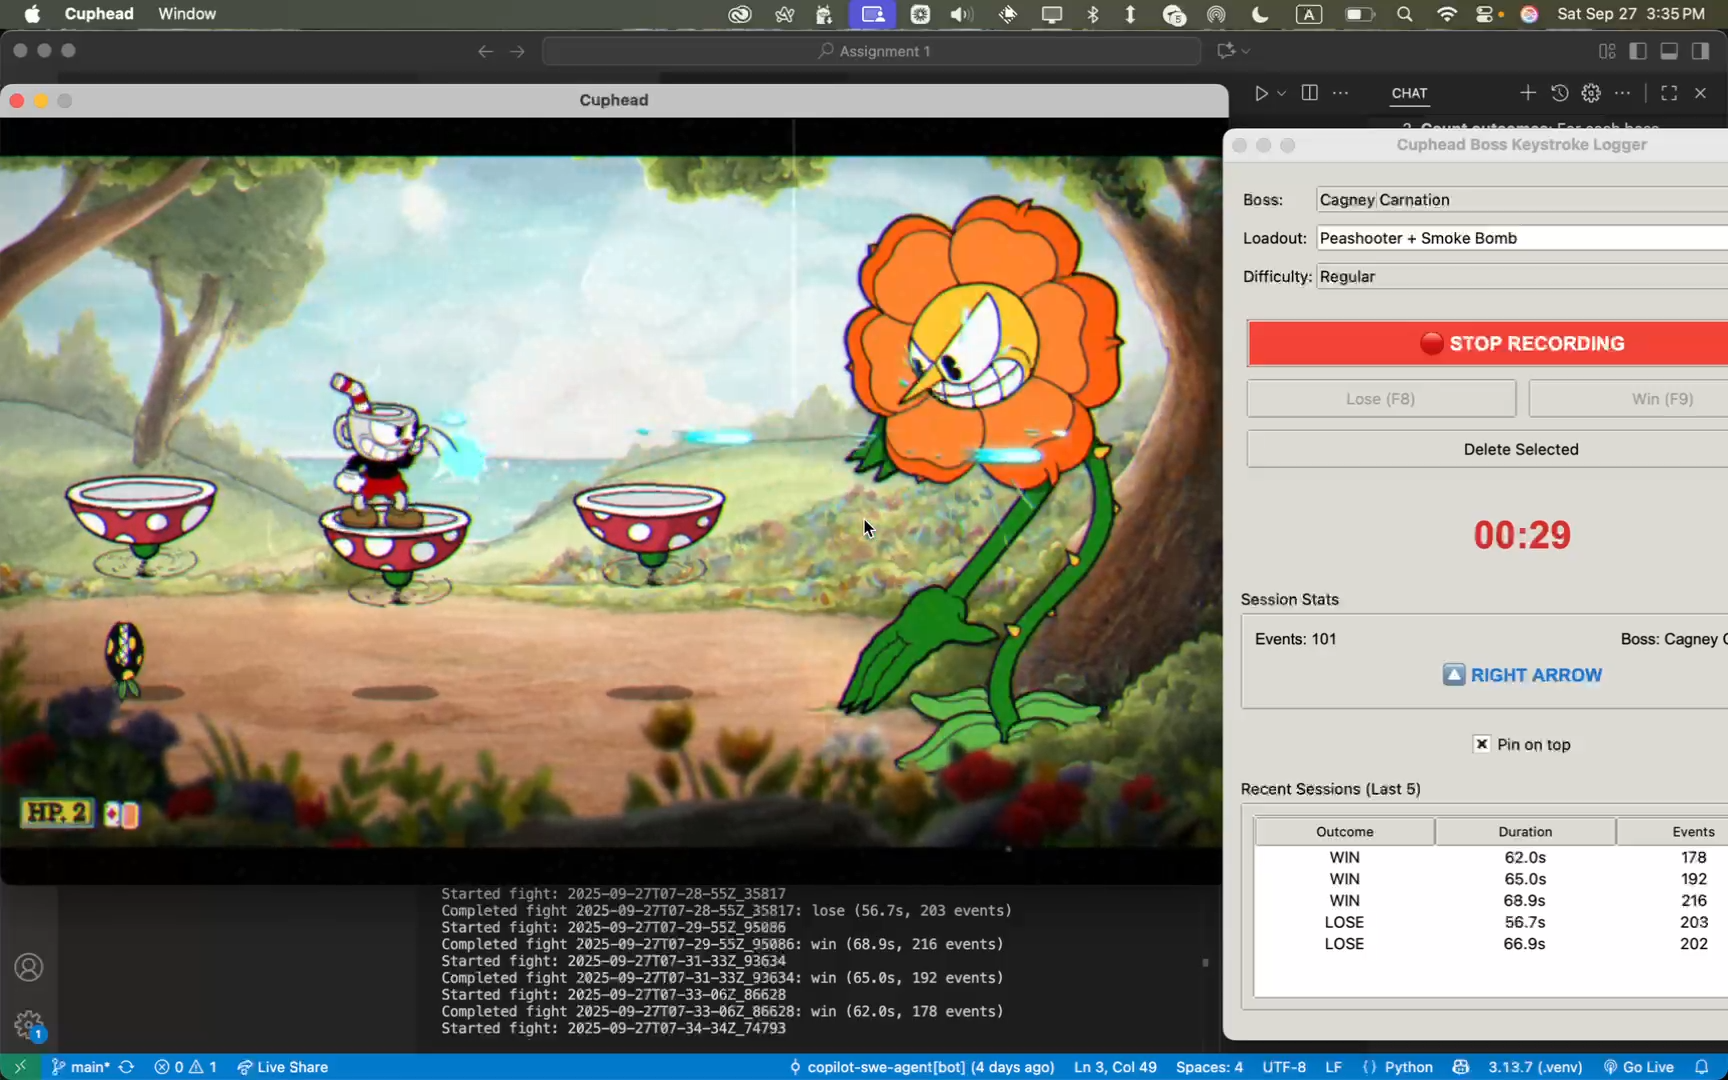

I developed a custom Python application using `Tkinter` for the UI and `pynput` for keyboard listening. The tool used global hotkeys to precisely mark the start and end of each fight, ensuring a clean and consistent dataset.

 Each session was saved as a **JSON Lines (.jsonl)** file containing metadata (loadout and difficulty are fixed), a full stream of timestamped keydown and keyup events, and a final summary of the outcome and duration.

 As the data comes entirely from my own playtime, it represents a convenience sample. 

 [Keystorke logger code base (Github)](https://github.com/ddanakim0304/CS156-Assignment-1/tree/main/app)

### A-2. Demo Video
#### Data Collection Recording (Old UI - 1h 18 min)

https://www.loom.com/share/29298ba8cc3140d0a84c9be8ac7e7394


#### Data Collection Recording (Latest UI - 8 min)
https://www.loom.com/share/94c7d83c027349d9a0a2fc186096ca72?sid=ae4d6bcb-923f-463b-8225-b8fc977820b4


### A-3. UI Design Evolution
The custom-built data logger underwent several design iterations to improve data quality and minimize human error. This iterative process was crucial for building a reliable dataset for analysis.

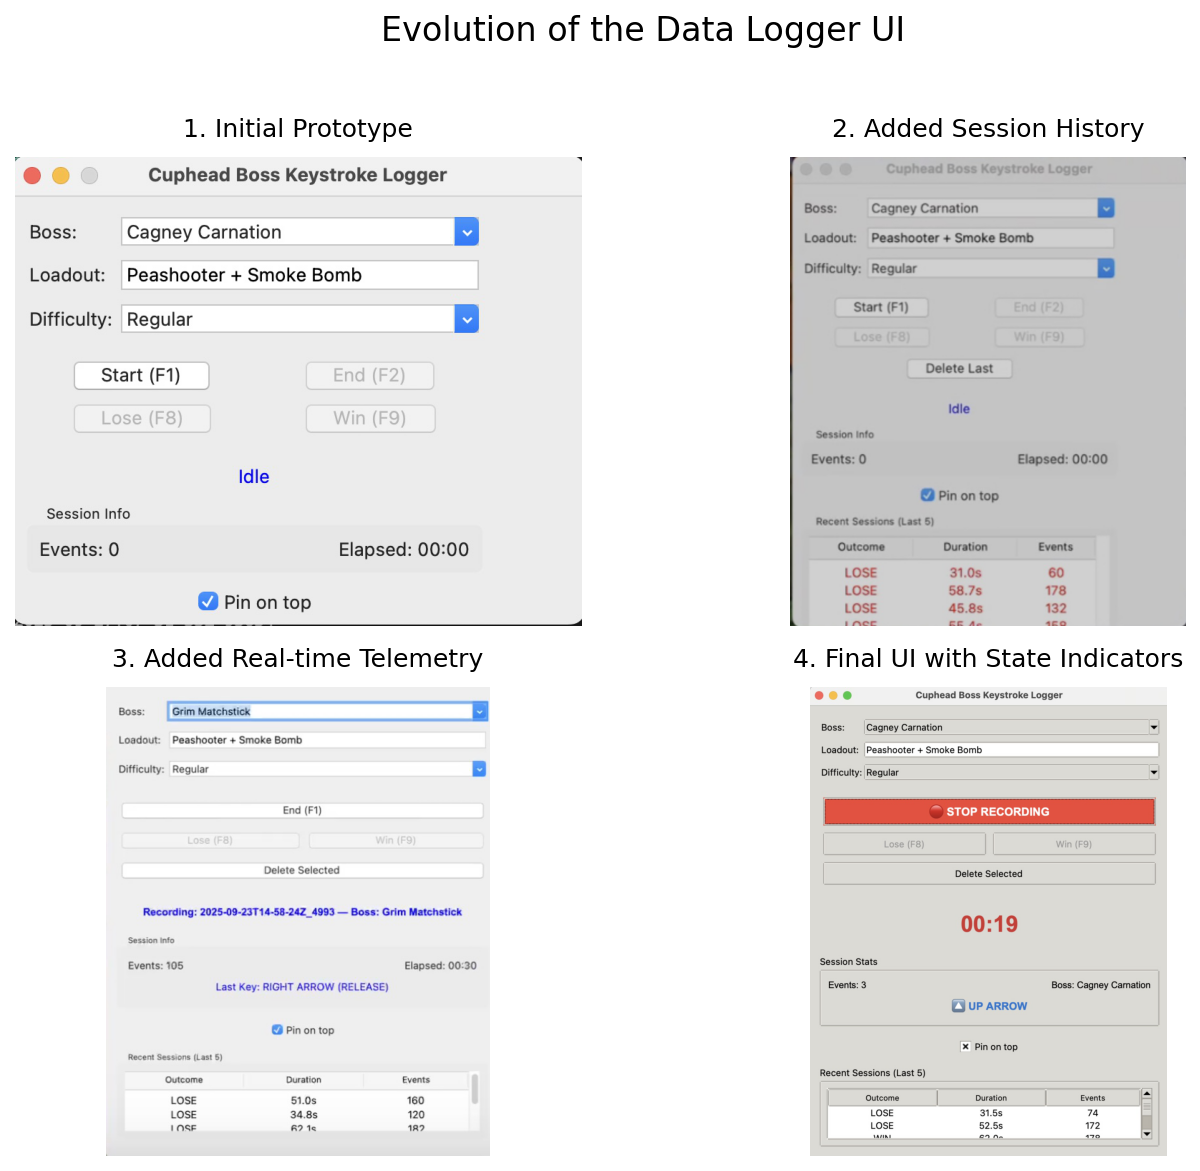
**Figure:** The evolution of the data logger UI, progressing from a basic logging utility to a feature-rich tool incorporating real-time feedback and history tracking for better data governance.

1.  **Initial Prototype:** The first version of the logger was minimalistic, featuring simple buttons and hotkeys. However, it provided no immediate feedback, making it difficult to spot erroneous recordings—such as forgetting to press "Start" until a fight was nearly over. (I spent countless time removing this accidental logs!!)

2.  **Introducing Feedback for Quality Control:** To address this, a "Recent Sessions" panel was added. This view immediately displayed the outcome, duration, and event count of the last five fights. This feature was instrumental in identifying anomalous data at a glance. For instance, a fight logged with a duration of $t < 10$ seconds and a very low event count was clearly an error. The UI allowed such entries to be immediately selected and deleted, preventing contamination of the final dataset.

3.  **Real-time Telemetry:** During initial testing, it became apparent that some keys were not being registered correctly by the listener. To validate the data stream in real time, the UI was updated to display the live elapsed time, total event count, and the most recent key action. This provided immediate confirmation that the logger was functioning as expected.

4.  **Final UI for Reduced Error:** The final design uses strong visual cues to prevent common mistakes. The "Start" button becomes a large, red "STOP RECORDING" button during a session, making the application's state unambiguous. Key telemetry like elapsed time and current keystrokes are given prominence. This user-centric design greatly increased the reliability of the collected data.

After the collection phase, a final data cleaning step was performed (Section 2). All fight logs with a duration of less than 5 seconds or less than 10 events than were removed to ensure that only valid gameplay sessions were included in the dataset.


## Appendix B: EDA Process & Analysis

Before boiling everything down to a few numbers, I wanted to actually *see* what the gameplay rhythm looks like. To do this, I created a Keystroke Timeline plot, which visualizes every single key press in a fight on a timeline, with the length of each bar showing exactly how long I held the button down.

I selected my longest successful ('win') attempt for this visualization. For Glumstone the Giant, where I didn't have a 'win' log in my sampled data, I chose my longest attempt to see the pattern.

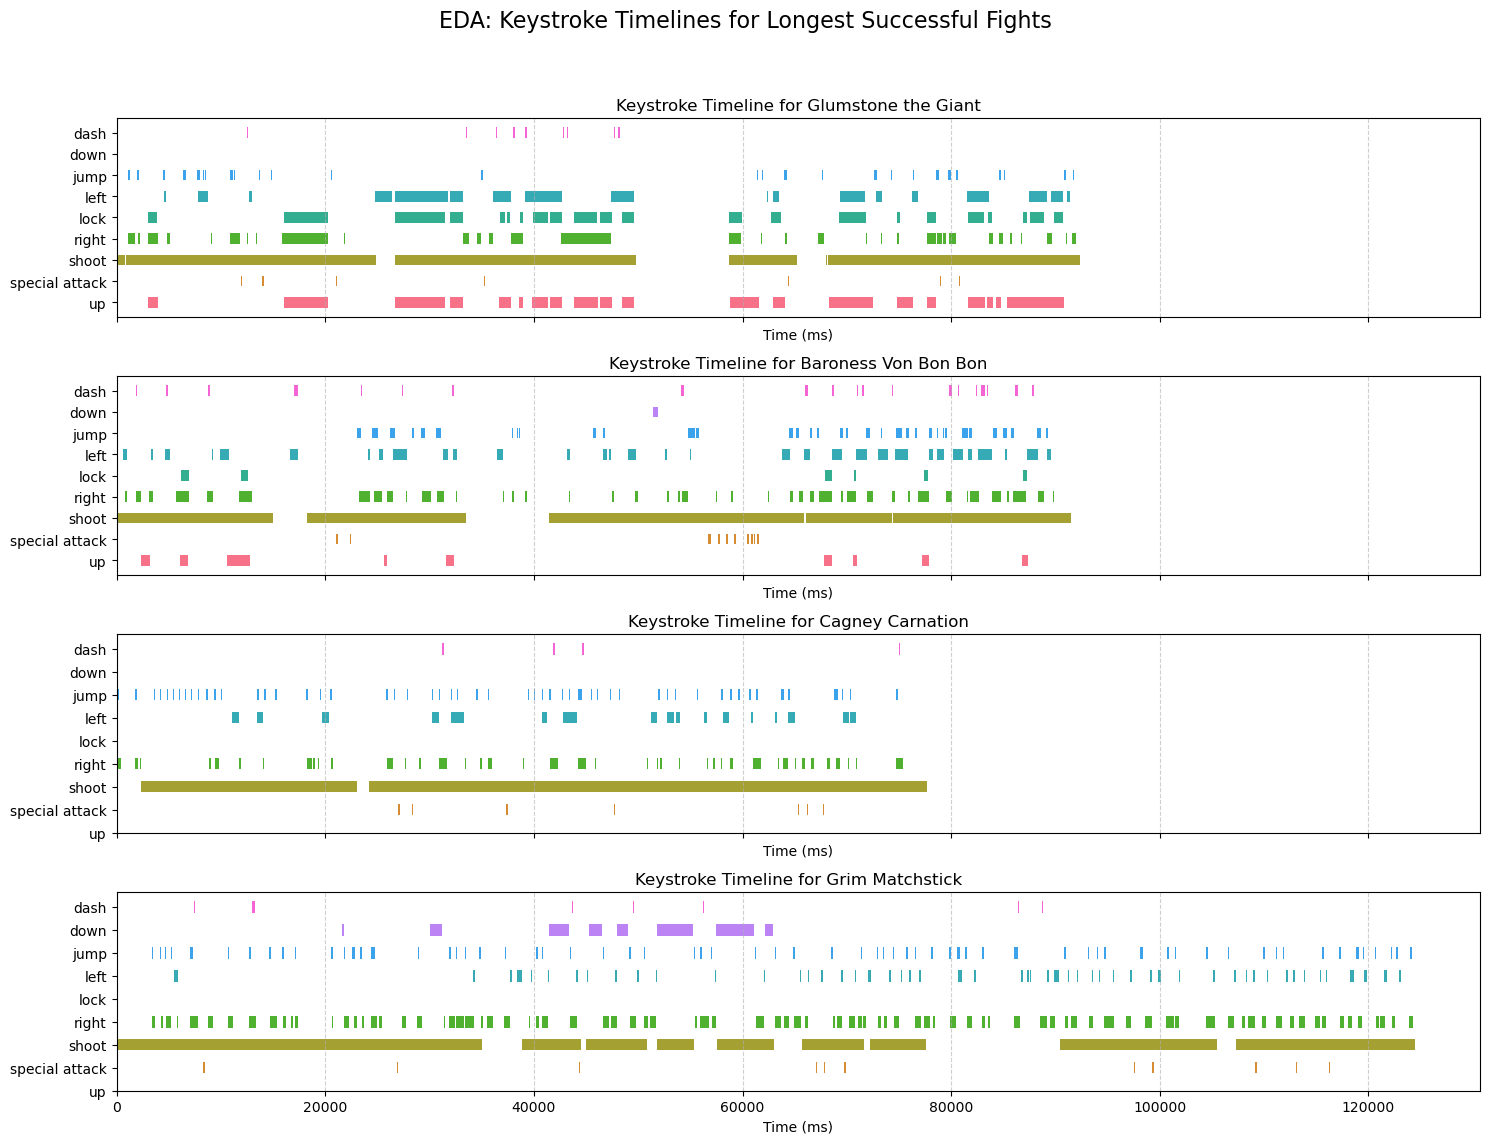

In [ ]:
# EDA: Visualizing the Raw Keystroke Timeline
# Gather fight outcomes and durations from the summary lines
fight_outcomes = {}
for file_path in glob.glob('../data/raw/*.jsonl'):
    fight_id = file_path.split('/')[-1].replace('.jsonl', '')
    with open(file_path, 'r') as f:
        try:
            last_line = f.readlines()[-1]
            summary = json.loads(last_line)['summary']
            fight_outcomes[fight_id] = {
                "outcome": summary.get('outcome'),
                "duration_ms": summary.get('duration_ms')
            }
        except (IndexError, json.JSONDecodeError, KeyError):
            continue

# Convert fight outcomes and durations to DataFrame for easy merging
outcomes_df = pd.DataFrame.from_dict(fight_outcomes, orient='index').reset_index().rename(columns={'index': 'fight_id'})

fight_ids_for_plot = []
boss_names = processed_df['boss'].unique()

for boss in boss_names:
    # Get all fight IDs for the current boss from the sampled dataset
    boss_fight_ids = processed_df[processed_df['boss'] == boss]['fight_id'].unique()
    
    # Merge with outcomes and durations
    boss_fights_df = outcomes_df[outcomes_df['fight_id'].isin(boss_fight_ids)]
    
    # Try to find the longest 'win'
    win_fights = boss_fights_df[boss_fights_df['outcome'] == 'win']
    
    if not win_fights.empty:
        # If there are wins, get the ID of the longest one
        longest_win_id = win_fights.sort_values('duration_ms', ascending=False).iloc[0]['fight_id']
        fight_ids_for_plot.append(longest_win_id)
    else:
        # If no wins, get the ID of the longest fight overall for that boss
        longest_fight_id = boss_fights_df.sort_values('duration_ms', ascending=False).iloc[0]['fight_id']
        fight_ids_for_plot.append(longest_fight_id)

# Prepare Color Mapping
all_possible_actions = sorted(processed_df['action'].unique(), reverse=True)
palette = sns.color_palette("husl", len(all_possible_actions))
global_color_map = dict(zip(all_possible_actions, palette))
global_action_map = {action: i for i, action in enumerate(all_possible_actions)}

def plot_fight_timeline(df, fight_id, ax, action_order, action_map, color_map):
    """Generates a Gantt-style chart with a consistent y-axis."""
    fight_data = df[df['fight_id'] == fight_id].copy()
    boss_name = fight_data['boss'].iloc[0] # Get boss name early
    ax.set_title(f"Keystroke Timeline for {boss_name}")
    
    # Calculate durations for this fight
    downs = fight_data[fight_data['event'] == 'keydown'].copy()
    ups = fight_data[fight_data['event'] == 'keyup'].copy()
    downs['press_num'] = downs.groupby(['fight_id', 'action']).cumcount()
    ups['press_num'] = ups.groupby(['fight_id', 'action']).cumcount()
    merged = pd.merge(downs, ups, on=['fight_id', 'boss', 'action', 'press_num'], suffixes=('_start', '_end'))
    durations = merged[merged['t_ms_end'] > merged['t_ms_start']].copy()
    
    # Only try to plot if there are valid durations to show
    if not durations.empty:
        durations['duration'] = durations['t_ms_end'] - durations['t_ms_start']
        bar_colors = durations['action'].map(color_map)
        ax.barh(y=durations['action'].map(action_map), 
                left=durations['t_ms_start'], 
                width=durations['duration'], 
                height=0.5,
                color=bar_colors)
            
    # Set consistent y-axis
    ax.set_yticks(range(len(action_order)))
    ax.set_yticklabels(action_order)
    ax.set_xlabel("Time (ms)")
    ax.grid(axis='x', linestyle='--', alpha=0.6)

# Create subplots for each selected fight
fig, axes = plt.subplots(len(fight_ids_for_plot), 1, figsize=(15, 12), sharex=True)
fig.suptitle('EDA: Keystroke Timelines for Longest Successful Fights', fontsize=16)

for i, fight_id in enumerate(fight_ids_for_plot):
    plot_fight_timeline(processed_df, fight_id, axes[i], all_possible_actions, global_action_map, global_color_map)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Analysis of Single-Fight Timelines
These timelines confirms my hypothesis. Grim Matchstick is a chaotic rhythm of extremely short, frequent taps on `'jump'` and `'left'`/`'right'`, reflecting constant platforming.

<img src="../photos/Grim.jpg" width="480">


Conversely, Glumstone the Giant shows long holds on `'up'` (the boss location is always high than the character). This proves that press duration and frequency are distinct.

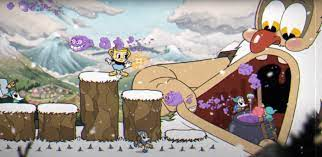

But how do we generalize this to all data? 🧐 This is only the the longest fight among 60 fights.

### Aggregated Heatmap

To see if these single-fight patterns hold true across the entire dataset, I aggregated the timing data into a heatmap. This visualizes the average press duration for every action against every boss.

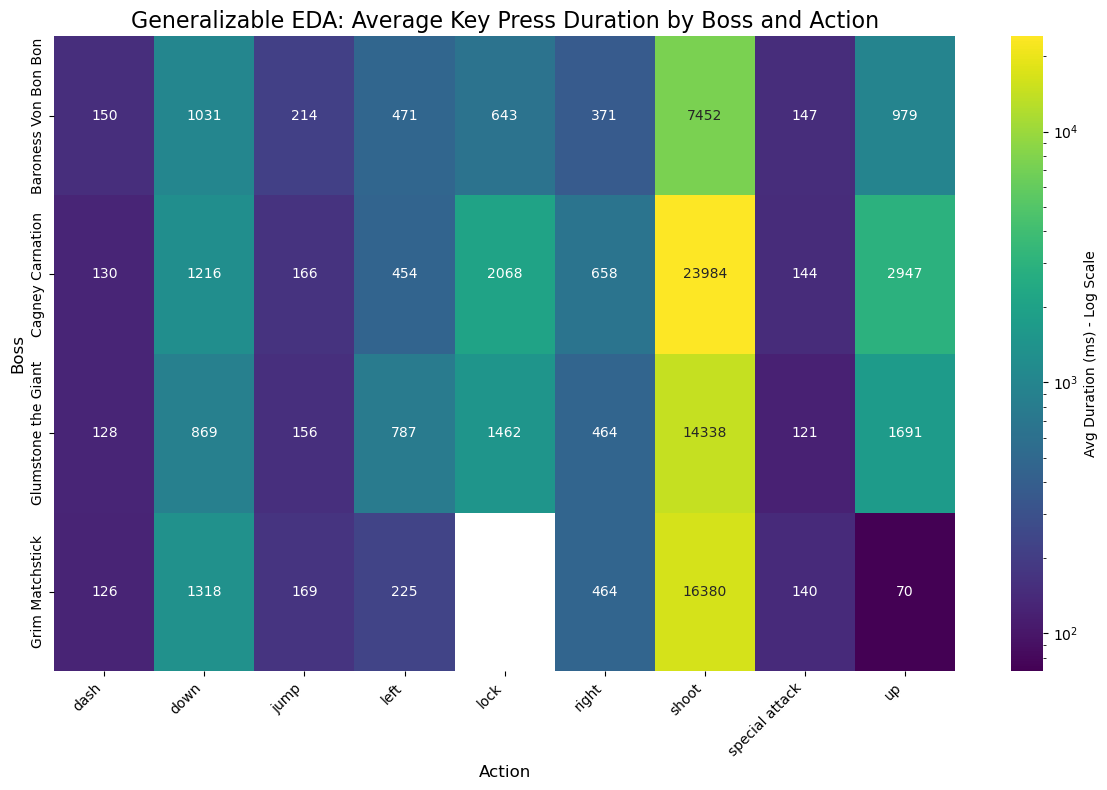

In [ ]:
# EDA: Generalized Heatmap of Press Durations

# calculate the press durations for all fights in the dataset
all_downs = processed_df[processed_df['event'] == 'keydown'].copy()
all_ups = processed_df[processed_df['event'] == 'keyup'].copy()

# Group by fight_id and action to correctly match each press to its release
all_downs['press_num'] = all_downs.groupby(['fight_id', 'action']).cumcount()
all_ups['press_num'] = all_ups.groupby(['fight_id', 'action']).cumcount()

all_merged = pd.merge(all_downs, all_ups, on=['fight_id', 'boss', 'action', 'press_num'], suffixes=('_down', '_up'))
all_merged['duration_ms'] = all_merged['t_ms_up'] - all_merged['t_ms_down']
all_durations = all_merged[all_merged['duration_ms'] >= 0]

# Create a pivot table to get the average duration for each (Boss, Action) pair
pivot_df = all_durations.groupby(['boss', 'action'])['duration_ms'].mean().unstack()

# Plot the Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    pivot_df, 
    annot=True,
    fmt=".0f",
    cmap="viridis",
    norm=LogNorm(),
    cbar_kws={'label': 'Avg Duration (ms) - Log Scale'}
)

plt.title('Generalizable EDA: Average Key Press Duration by Boss and Action', fontsize=16)
plt.xlabel('Action', fontsize=12)
plt.ylabel('Boss', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

### Analysis of Generalized Patterns
This heatmap confirms the trends, like Grim Matchstick's `up` key is a uniquely short and `shoot` key is long compared to other bosses. 

However, **relying solely on this grand average is deceptive**, as it's skewed by the wide variance in my fight lengths and compresses the entire distribution of press times into a single number

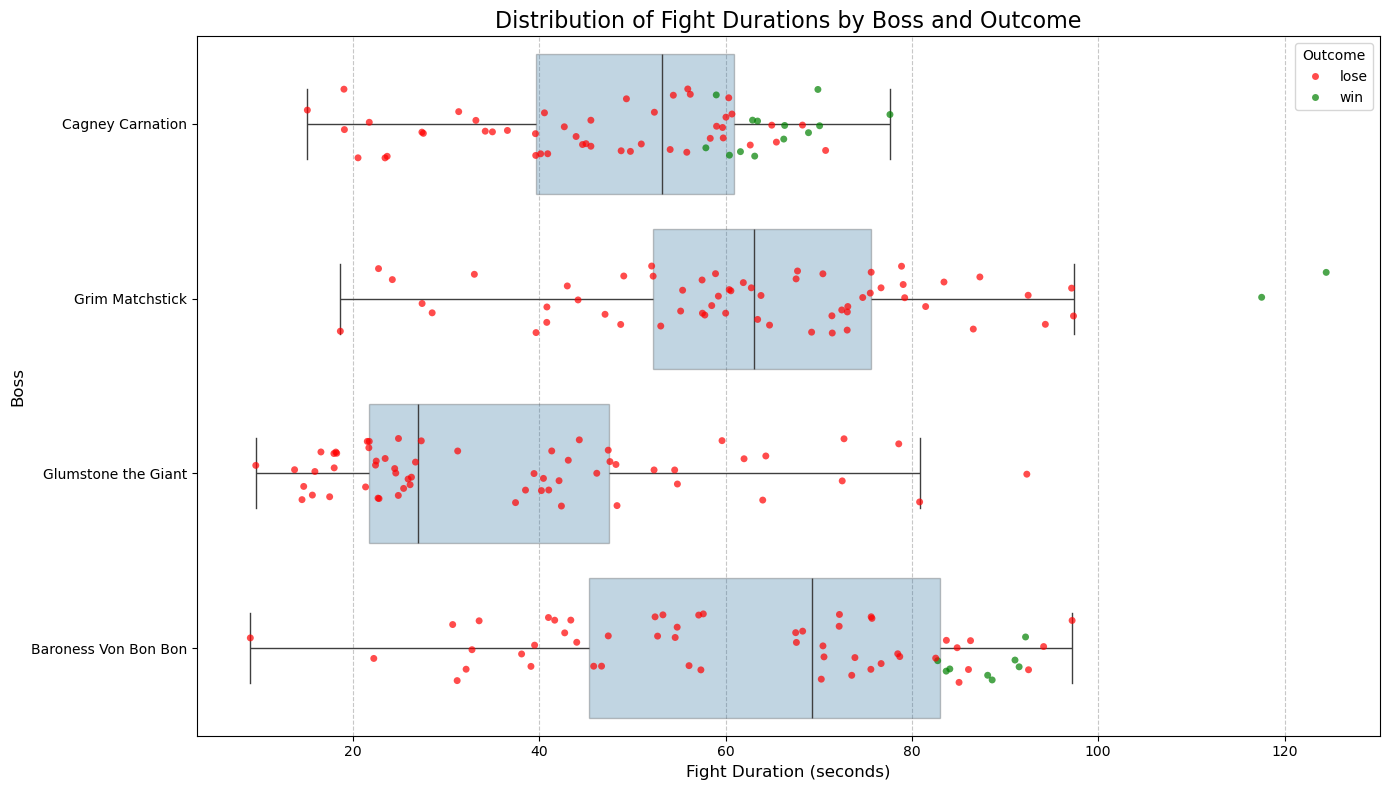

In [ ]:
# EDA: Visualizing Fight Duration Distribution by Outcome
fight_summaries_for_plot = final_df.groupby('fight_id').agg(
    duration_ms=('t_ms', 'max'),
    boss=('boss', 'first')
).reset_index()

fight_summaries_for_plot['duration_s'] = fight_summaries_for_plot['duration_ms'] / 1000
# Merge with outcomes to get the outcome for each fight
plot_data = pd.merge(fight_summaries_for_plot, outcomes_df, on='fight_id', suffixes=('', '_from_summary'))
plt.figure(figsize=(14, 8))
outcome_palette = {'win': 'green', 'lose': 'red'}

# draw the boxplots to show the summary statistics
sns.boxplot(
    data=plot_data, 
    y='boss', 
    x='duration_s', 
    orient='h',
    showfliers=False,  # Hide outlier points from the boxplot itself
    boxprops=dict(alpha=.3) # Make boxes slightly transparent
)

# overlay the stripplot to show every individual fight
sns.stripplot(
    data=plot_data, 
    y='boss', 
    x='duration_s', 
    hue='outcome',
    orient='h',
    jitter=0.2,
    alpha=0.7,
    palette=outcome_palette
)

plt.title('Distribution of Fight Durations by Boss and Outcome', fontsize=16)
plt.xlabel('Fight Duration (seconds)', fontsize=12)
plt.ylabel('Boss', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.legend(title='Outcome')
plt.tight_layout()
plt.show()

### B-2 Feature Strategy

| Feature Strategy | Pros | Cons | Status | How Cons are Addressed |
| :--- | :--- | :--- | :--- | :--- |
| **Fixed Time Slices** | - Attempts to capture temporal evolution of gameplay. | - Creates sparse/misaligned vectors from variable-length data.<br>- High risk of overfitting due to feature explosion. | **Rejected** | N/A |
| **Proportional Time Slicing** | - Solves the variable-length issue by dividing fights into percentage-based chunks (10 chunks of 10% each). | - Boss phases are triggered by damage, not time. A 10% time slice might be phase 1 in a long fight but phase 2 in a short one, making the features non-comparable. | **Rejected** | N/A |
| **Recurrent Neural Networks (RNN/LSTM)**| - The most powerful method for modeling raw sequential data directly. | - High implementation complexity (padding, vectorization).<br>- Prone to overfitting on smaller datasets (240 samples). | **Rejected (For this assignment)** | N/A (A great candidate for future work with more data.) |
| **Aggregate Statistical Features** | - Directly captures variability (`std`, `median`).<br>- Creates a dense, fixed-size vector for every fight.<br>- Robust to outliers and varying fight lengths. | - Loses all information about the **sequence** of actions (ex. is a `dash` usually preceded by a `jump`?). | **Accepted (Foundational)**| This con is directly complemented by using **N-gram Features**. |
| **N-gram Sequence Features** | - Captures the order and rhythm of common action combos.<br>- Adds crucial sequential context to the model. | - Loses all precise **timing** information (e.g., the duration of the presses or the time between them). | **Accepted (Enrichment)**| This con is directly complemented by the **Aggregate Statistical Features**. |

### Appendix C: N-gram Mathematical Explanation & Pseudocode

An N-gram is a contiguous sequence of *n* items from a given sample of text or sequence. For a sequence of actions $A = (a_1, a_2, ..., a_T)$, a bigram (2-gram) is a pair $(a_i, a_{i+1})$. The process of creating N-gram features involves two main steps:

1.  **Vocabulary Creation:** The algorithm first scans the entire corpus of action sequences (all 240 fights) to identify all unique N-grams (ex. `'jump dash'`, `'shoot lock'`). The top *k* most frequent N-grams are selected to form the feature "vocabulary," $V = \{ngram_1, ngram_2, ..., ngram_k\}$.

2.  **Vectorization:** For each individual fight, the algorithm creates a feature vector $\mathbf{x}_{ngram}$ of length *k*. Each element $j$ in this vector, $\mathbf{x}_{ngram, j}$, is the count of how many times $ngram_j$ from the vocabulary appears in that fight's action sequence. This is a Term Frequency (TF) representation.

In [ ]:
FUNCTION ExtractNGrams(sequence, n):
    """
    Extracts all contiguous sub-sequences of length n from a given sequence.

    Args:
        sequence (list): An ordered list of items (e.g., actions ['jump', 'dash', 'shoot']).
        n (int): The size of the N-gram to extract (e.g., 2 for bigrams).

    Returns:
        list: A list of all N-grams found in the sequence.
              Example: ExtractNGrams(['jump', 'dash', 'shoot'], 2) -> [('jump', 'dash'), ('dash', 'shoot')]
    """
    
    ngrams = new List()
    
    // Iterate through the sequence, stopping when the remaining part
    // is shorter than the desired N-gram size 'n'.
    FOR i from 0 to length(sequence) - n:
        // Slice the sequence from the current index 'i' to 'i+n'
        // to create a sub-sequence of length 'n'.
        ngram = sequence[i : i+n]
        
        // Add the newly created N-gram to the list of results.
        append ngram to ngrams
        
    RETURN ngrams

### Appendix D: N-gram Visualization

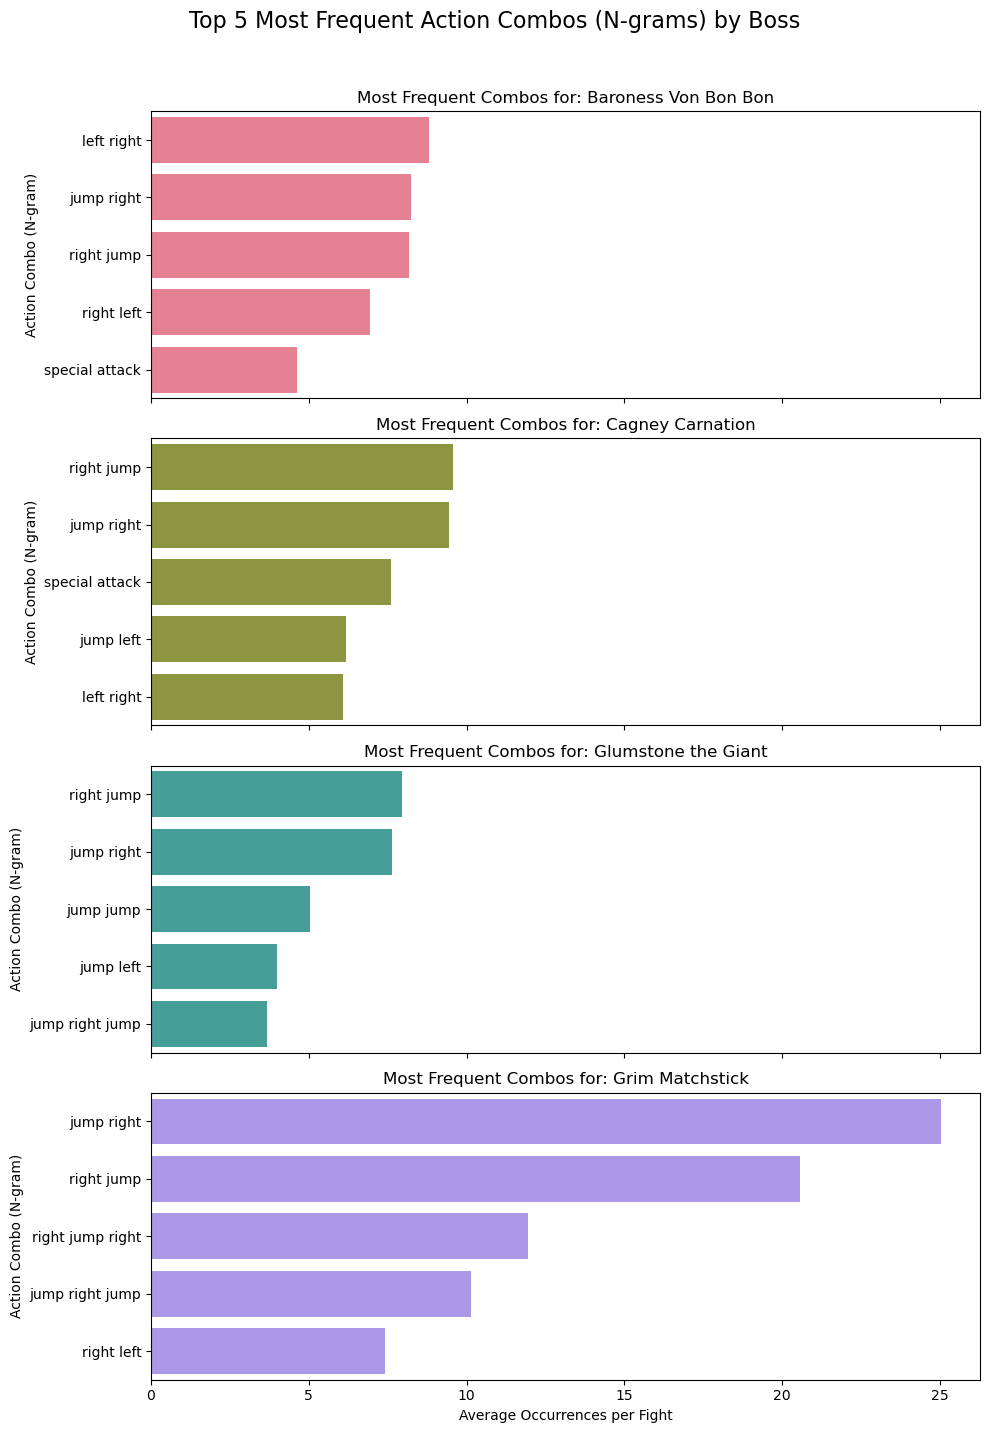

In [ ]:
# 1. Create a DataFrame of N-gram Frequencies with Labels

# Get the names of the 50 N-gram features from the vectorizer
ngram_names = vectorizer.get_feature_names_out()

# Create a dense pandas DataFrame from the sparse matrix
# Use the fight_id index from fight_actions_str to correctly label each row
ngram_df = pd.DataFrame(ngram_features_sparse.toarray(), columns=ngram_names, index=fight_actions_str.index)
ngram_df['boss'] = y_str

# 2. Calculate the Mean Frequency of Each N-gram per Boss
# get the average number of times each combo appears per fight for each boss
mean_ngram_freq = ngram_df.groupby('boss').mean()


# 3. Visualize the Top 5 N-grams for Each Boss
boss_names = mean_ngram_freq.index
n_bosses = len(boss_names)

# Prepare Color Mapping
boss_palette = sns.color_palette("husl", n_bosses)
boss_color_map = dict(zip(boss_names, boss_palette))

# Create subplots, one for each boss
fig, axes = plt.subplots(n_bosses, 1, figsize=(10, 14), sharex=True)
fig.suptitle('Top 5 Most Frequent Action Combos (N-grams) by Boss', fontsize=16, y=1.02)

for i, boss_name in enumerate(boss_names):
    # Get the top 5 combos for the current boss
    top_5 = mean_ngram_freq.loc[boss_name].nlargest(5)
    
    # Create the horizontal bar plot
    sns.barplot(
        x=top_5.values, 
        y=top_5.index, 
        ax=axes[i], 
        color=boss_color_map[boss_name],
        orient='h'
    )
    
    axes[i].set_title(f'Most Frequent Combos for: {boss_name}', fontsize=12)
    axes[i].set_xlabel('Average Occurrences per Fight')
    axes[i].set_ylabel('Action Combo (N-gram)')

plt.tight_layout()
plt.show()